# Bar & Omer real-estate data science project

importing needed libraries:

In [1]:
# -*- coding: utf-8 -*-
import json
import time
import selenium
from selenium import webdriver
from selenium.common import NoSuchElementException, TimeoutException
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import numpy as np
import re
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split # data split

from sklearn.linear_model import LinearRegression # OLS algorithm
from sklearn.linear_model import Ridge # Ridge algorithm
from sklearn.linear_model import Lasso # Lasso algorithm
from sklearn.linear_model import BayesianRidge # Bayesian algorithm
from sklearn.linear_model import ElasticNet # ElasticNet algorithm

from sklearn.metrics import explained_variance_score as evs # evaluation metric
from sklearn.metrics import r2_score as r2 # evaluation metric
#ignore annoying warning (from sklearn and seaborn)
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 
get_ipython().run_line_magic('matplotlib', 'inline')

All of our functions:

In [2]:

def count_duplicatives(df, col_name=None):
    if(col_name != None):
        count = df.duplicated([col_name]).sum()
        return count
    else:
        count = df.duplicated().sum()
        return count
    
##########################

def remove_duplicatives(df, col_name=None):
    if(col_name != None):
        new_df = df.drop_duplicates(subset=[col_name],keep='first')
        return new_df
    else:
        new_df = df.drop_duplicates(keep='first')
        return new_df
    
##########################

def outlier_detection_iqr(df):
    numeric_cols = ["levels_in_building","year_of_apartment_builded","year_of_structare_builded"
,'price','size_in_meters','room_number' , 'lowest_floor', 'highest_floor' , 'total_floors']  
    for col in numeric_cols:
        q1 = np.percentile(df[col], 25)
        q3 = np.percentile(df[col], 75)
        iqr = q3 - q1
        iqr_range = 1.5 * iqr
        df.loc[(df[col] < q1 - iqr_range) | (df[col] > q3 + iqr_range), col] = np.nan
        
    return df.copy()

##########################

def is_attribute_present(element, attribute):
    result = False  # Initialize the result to False
    try:
        value = element.get_attribute(attribute)  # Attempt to get the value of the attribute
        if value is not None:  # If the attribute has a value, set the result to True
            result = True
    except:  # Catch any exceptions that occur (and ignore them)
        pass

    return result  # Return the result

##########################

def check_exists_by_xpath(xpath):
    try:
        webdriver.find_element(By.XPATH, xpath)
    except NoSuchElementException:
        return False
    return True

##########################

def have_next_page():
    temp = driver.find_element(By.ID("paging"))
    temp1 = temp.find_element(By.TAG_NAME, 'a').is_enabled()
    if (temp1):
        return True
    else:
        return False

##########################

def write_list(a_list, city_name):
    print("Started writing list data into a json file")
    with open(f"{city_name}.json", "w") as fp:
        json.dump(a_list, fp)
        print("Done writing JSON data into .json file")

##########################

def read_list(city_name):
    # for reading also binary mode is important
    with open(f'{city_name}.json', 'rb') as fp:
        n_list = json.load(fp)
        return n_list
    
##########################

def homeless_read_list(city_name):
    # for reading also binary mode is important
    with open(f'Untitled Folder/{city_name}.json', 'rb') as fp:
        n_list = json.load(fp)
        return n_list
    
##########################

def fill_nan_with_other_column(df, column_to_fill, reference_column):
    df[column_to_fill] = df[column_to_fill].fillna(df[reference_column])
    return df.copy()


##########################

def remove_commas(df, column_name):
    if df[column_name].dtype == object:
        df[column_name] = df[column_name].str.replace(',', '')
    return df

##########################

def create_scatter_plots(df):
    numeric_columns = df.select_dtypes(include='number').columns

    # Generate scatter plots for each pair of numeric columns
    for i in range(len(numeric_columns)):
        for j in range(i + 1, len(numeric_columns)):
            column1 = numeric_columns[i]
            column2 = numeric_columns[j]

            plt.scatter(df[column1], df[column2])
            plt.xlabel(column1)
            plt.ylabel(column2)
            plt.title(f'Scatter Plot: {column1} vs {column2}')
            plt.show()
            
##########################
            
def create_line_plots(df):
    numeric_columns = df.select_dtypes(include='number').columns

    # Generate line plots for each pair of numeric columns
    for i in range(len(numeric_columns)):
        for j in range(i + 1, len(numeric_columns)):
            column1 = numeric_columns[i]
            column2 = numeric_columns[j]

            plt.plot(df[column1], df[column2])
            plt.xlabel(column1)
            plt.ylabel(column2)
            plt.title(f'Line Plot: {column1} vs {column2}')
            plt.show()
            
##########################

def calculate_average_increase(df, percent_column, years_column):
    df['percentage_increase_per_year'] = df[percent_column] / df[years_column]
    return df

##########################

def feat_importance(m,df_train):
    importance = m.feature_importances_
    importance = pd.DataFrame(importance,index=df_train.columns,columns=["Importance"])
    return importance.sort_values(by=['Importance'],ascending=False)
 

##########################

def replace_categories(data, var, target):

    # order the categories in a variable from that with the lowest
    # house sale price, to that with the highest
    ordered_labels = data.groupby([var])[target].mean().sort_values().index

    # create a dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}

    # use the dictionary to replace the categorical strings by integers
    data[var] = data[var].map(ordinal_label)

the following function take column of string values that represent which floors levels are included in the estate - and convert to new three numerical columns: lowest_floor, highest_floor and total floors.
this function is for cleaning the data stage.

In [3]:
def process_floor_data(floor_values, df, column_name):
    new_df = df.copy()
    min_range = []
    max_range = []
    range_values = []

    for string in new_df[column_name]:
        values = []
        for key in floor_values:
            #pattern = rf"(?<!\S)(?i){re.escape(key)}(?!{re.escape(''.join(floor_values.keys()))})"
            pattern = rf"(?i)(?<!\S){re.escape(key)}(?!{re.escape(''.join(floor_values.keys()))})"

            matches = re.findall(pattern, string)
            if matches:
                values.extend([floor_values[key]] * len(matches))

        if values:
            min_val = min(values)
            max_val = max(values)
            min_range.append(min_val)
            max_range.append(max_val)
            if (max_val - min_val == 0 or min_val - max_val == 0):
                range_values.append(1)
            else:    
                range_values.append(max_val - min_val + 1)
        else:
            min_range.append(0)
            max_range.append(0)
            range_values.append(0)

    new_df['lowest_floor'] = min_range
    new_df['highest_floor'] = max_range
    new_df['total_floors'] = range_values

    return new_df

the following function take column of string values that represent Upward trend percent and the time of the trend - and convert the data to numerical value, make two new columns and put the new numerical data in.

In [4]:

def extract_numbers(df):
    percent_pattern = r'\d+'
    years_pattern = r'\d+'
    percent_column_name = 'percent_megamat_alyia'
    years_column_name = 'in_how_many_years_megamat_alyia'

    percent_values = []
    years_values = []
    original_values = []

    for index, row in df.iterrows():
        percent_match = re.findall(percent_pattern, str(row['megamat_aliya']))
        years_match = re.findall(years_pattern, str(row['megamat_aliya']))

        if percent_match:
            percent_values.append(int(percent_match[0]))
        else:
            percent_values.append(None)

        if len(years_match) > 1:
            years_values.append(int(years_match[1]))
        else:
            years_values.append(None)

        original_values.append(row.values.tolist())

    new_columns = df.columns.tolist() + [percent_column_name, years_column_name]
    new_values = original_values

    for i in range(len(new_values)):
        new_values[i].extend([percent_values[i], years_values[i]])

    new_df = pd.DataFrame(new_values, columns=new_columns)
    return new_df

our goal is to predict the price of an apartment.

# 1. Scraping

## homeless.co.il scraper

 lets start with the homeless.co.il scraper - we wanted to get data of apartments of cities in israel.

In [5]:

# path = r"C:\Users\barta\Downloads\chromedriver_win32\chromedriver.exe"
# driver = webdriver.Chrome(path)
# url = "https://www.homeless.co.il/sale/"
# driver.get(url)
# driver.implicitly_wait(2)

# #############

# soragim = True
# furniture = True
# elevator = True
# balcony = True
# mamad = True
# storage = True
# negishut = True
# sun_dud = True
# parking = True
# mizug = True
# array = [soragim,furniture,elevator,balcony,mamad,storage,negishut,sun_dud,parking,mizug]
# level = ''
# enter_date = True
# contact = True
# rooms = ''
# price = ''
# size_in_meters = ''
# sample = []
# samples = []
# holon = "חולון"
# azor = "אזור"
# nahar = "נהריה"
# cities = ["תל אביב יפו", "רחובות", "פתח תקווה","בת ים", "חולון", "אור יהודה", "רמת גן", "גבעתיים", "בני ברק", "רמת השרון", "הרצליה", "אזור", "כפר שמריהו", "ראשון לציון", "נס ציונה", "קרית אונו", "באר יעקב", "רמלה", "לוד", "יהוד מונוסון", "גני תקווה", "גבעת שמואל", "הוד השרון", "כפר סבא", "רעננה","ראש העין", "קריית עקרון", "בית דגן","שדות דן","אשדוד" , "נתניה", "יבנה", "קריית מלאכי", "מודיעין מכבים רעות", "אלעד", "אריאל", "כפר קאסם", "טייבה", "טירה", "כפר יונה","מזכרת בתיה", "שוהם", "אורנית", "אלקנה", "עמנואל", "אלפי מנשה", "קרני שומרון", "קדומים", "כוכב יאיר", "קדימה צורן", "אבן יהודה", "גדרות"," מודיעין עילית","שומרון"]

# #############

# for city in cities:
#     samples = []
#     try:
#         search = WebDriverWait(driver, 10).until(
#         EC.presence_of_element_located((By.ID, "city")))
#     except:
#         driver.implicitly_wait(1)

#     search.send_keys(city)
#     element = driver.find_element(By.CLASS_NAME, 'sub_btn')
#     element.click()

#     while(1):

#         city_url = driver.current_url

#         try:
#             main_results = WebDriverWait(driver, 10).until(
#                 EC.presence_of_element_located((By.ID, "mainresults")))
#         except (NoSuchElementException, TimeoutException):
#             break

#         main_results = driver.find_element(By.ID, 'mainresults')
#         links = main_results.find_elements(By.TAG_NAME, 'a')

#         #ads = driver.find_elements(By.CLASS_NAME,'ad')

#         try:
#             highlight_ads = WebDriverWait(driver, 10).until(
#                 EC.presence_of_element_located((By.CLASS_NAME, "pormoted_ads"))
#             )
#         except:
#             driver.implicitly_wait(3)

#         hrefs = []

#         for link in links:
#             href = link.get_attribute('href')
#             hrefs.append(href)


#         for link in hrefs:
#             sample = []
#             driver.get(link)
#             driver.implicitly_wait(5)
#             try:
#                 main_ad_parameters = WebDriverWait(driver, 10).until(
#                     EC.presence_of_element_located((By.ID, "ctl00_ContentPlaceHolder1_MainDetails_AdPanel")))
#             except (NoSuchElementException, TimeoutException):
#                 break
#             main_ad_parameters = driver.find_element(By.ID,"ctl00_ContentPlaceHolder1_MainDetails_AdPanel")
#             bool_elements = main_ad_parameters.find_elements(By.CLASS_NAME, 'itemsAd')

#             sample.append(city)

#             # rooms property extraction:

#             element_rooms = driver.find_element(by=By.XPATH,value="/html/body/form/div[4]/div[3]/div[1]/div[2]/div[3]/div/div[1]/div/div/div/h1")
#             num_of_rooms = element_rooms.text
#             sample.append(num_of_rooms)

#             # meter property extraction:

#             element_meter = driver.find_element(by=By.XPATH,value='/html/body/form/div[4]/div[3]/div[1]/div[2]/div[3]/div/div[3]/div[2]/div/div[2]/div/div/div/div[22]/span')
#             size_in_meters = element_meter.text
#             sample.append(size_in_meters)

#             # price property extraction:

#             element_price = driver.find_element(by=By.XPATH,value='/html/body/form/div[4]/div[3]/div[1]/div[2]/div[3]/div/div[3]/div[2]/div/div[2]/div/div/div/div[29]/span')
#             price = element_price.text
#             sample.append(price)
#             # level property extraction:

#             element_level = driver.find_element(by=By.XPATH,value='/html/body/form/div[4]/div[3]/div[1]/div[2]/div[3]/div/div[3]/div[2]/div/div[2]/div/div/div/div[23]/span')
#             level = element_level.text
#             sample.append(level)
#             samples.append(sample)

#             for feature in bool_elements:
#                 # masheu.find_element(By.CSS_SELECTOR,"input[name*='response']")
#                 # exist = is_attribute_present(feature, "src")
#                 src = feature.get_attribute('src')
#                 temp = True
#                 if (src == 'https://www.homeless.co.il/Images/uncheked.png'):
#                     temp = False
#                     sample.append(temp)
#                 else:
#                     sample.append(temp)

#             print(f"{sample}\n")

#         driver.get(city_url)
#         result = True
#         try:
#             temp0 = WebDriverWait(driver, 10).until(
#                 EC.presence_of_element_located((By.ID, "main_paging")))
#         except (NoSuchElementException, TimeoutException):
#             break
#         temp0 = driver.find_element(By.ID, "main_paging")
#         try:
#             temp2 = temp0.find_element(By.TAG_NAME, 'a')
#         except NoSuchElementException:
#             break
#         href = temp2.get_attribute('href')
#         if(not(isinstance(href, str))):
#             break
#         driver.get(href)

#     driver.get(url)
#     write_list(samples,city)
#     print("####################### END OF CITY #######################\n")


 merging the json files to pandas dataframe:

In [6]:
# soragim = []
# furniture = []
# elevator = []
# balcony = []
# mamad = []
# storage =[]
# negishut =[]
# sun_dud = []
# parking = []
# mizug = []
# level = []
# price = []
# size_in_meters = []
# rooms = []
# citys = []

# #############

# cities_completed = ["תל אביב יפו", "רחובות", "פתח תקווה","בת ים","ירושלים" ,"חולון", "אור יהודה", "רמת גן", "גבעתיים", "בני ברק", "רמת השרון", "הרצליה", "אזור", "כפר שמריהו", "ראשון לציון", "נס ציונה", "קרית אונו", "באר יעקב", "רמלה", "לוד", "יהוד מונוסון", "גני תקווה", "גבעת שמואל", "הוד השרון", "כפר סבא", "רעננה","ראש העין", "קריית עקרון", "בית דגן","שדות דן","אשדוד" , "נתניה", "יבנה", "קריית מלאכי", "מודיעין מכבים רעות", "אלעד", "אריאל", "כפר קאסם", "טייבה", "טירה", "כפר יונה","מזכרת בתיה", "שוהם", "אורנית", "אלקנה", "עמנואל", "אלפי מנשה", "קרני שומרון", "קדומים", "כוכב יאיר", "קדימה צורן", "אבן יהודה", "גדרות","שומרון"]
# new_cities = ['חיפה','כרמיאל','נהריה','באר שבע','אילת','דימונה','טבריה','עפולה','עכו']
# new_cities1 = ['חדרה','בית שמש','קרית מלאכי','נתיבות','קרית גת','אשקלון','ביתר עילית','יקנעם','זכרון יעקב']
# all_cities = cities_completed + new_cities + new_cities1
# cities_needs_modify = ["תל אביב יפו", "רחובות", "פתח תקווה" ]

# #############

# for city in all_cities:
#     temp = homeless_read_list(city)
#     for dira in temp:
#         soragim.append(dira[14])
#         furniture.append(dira[13])
#         elevator.append(dira[12])
#         balcony.append(dira[11])
#         mamad.append(dira[10])
#         storage.append(dira[9])
#         negishut.append(dira[8])
#         sun_dud.append(dira[7])
#         parking.append(dira[6])
#         mizug.append(dira[5])
#         level.append(dira[4])
#         price.append(dira[3])
#         size_in_meters.append(dira[2])
#         rooms.append(dira[1])
#         citys.append(dira[0])
        
#     #print("#################### END OF CITY ####################")


# my_dictionary = {'soragim': soragim,'furniture':furniture,'elevator':elevator,'balcony':balcony,'mamad':mamad,'storage':storage,
#                  'negishut':negishut,'sun_dud':sun_dud,'parking':parking,'mizug':mizug,'level':level,'price':price,
#                  'size_in_meters':size_in_meters,'rooms':rooms}
# homeless_df = pd.DataFrame.from_dict(my_dictionary)
# homeless_df

we end up not using the homeless.co.il data we created because we think the data of the prices is irrelevant for us because the asked price is almost never the actual price. 

## nadlan.gov scraper

we continue to nadlan.gov scraper
on homeless site the links of every apartment is static and available - which helped us to get the data easely and fast.
in nadlan.gov site every link for the apartments and the cities was hidden behind buttons and dynamic.
we couldnt access them directly.
we had to approch the scraping in manual way.
every city url has a table of all the streets in the city. every row of the table is 3 streets.
first we catched the table size and then we accessed every row with indexed for loop.
every row that was sucessfully scraped was printed to the terminal for validation.
the site is unstable so the scraper crashed every 100 rows - by knowing the index row of the crash
we know where to continue to scrape.

In [7]:
# Data tuples of city name and link for our scraper:

tel_aviv = ('תל אביב יפו',
            'https://www.nadlan.gov.il/Pricing?cityName=%D7%AA%D7%9C%20%D7%90%D7%91%D7%99%D7%91%20-%D7%99%D7%A4%D7%95')
or_yehuda = (
'אור יהודה', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%90%D7%95%D7%A8%20%D7%99%D7%94%D7%95%D7%93%D7%94')
azur = ('אזור', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%90%D7%96%D7%95%D7%A8')
eilat = ('אילת', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%90%D7%99%D7%9C%D7%AA')
ashdod = ('אשדוד', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%90%D7%A9%D7%93%D7%95%D7%93')
petah_tikva = (
'פתח תקווה', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%A4%D7%AA%D7%97%20%D7%AA%D7%A7%D7%95%D7%95%D7%94')
rehovot = ('רחובות', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%A8%D7%97%D7%95%D7%91%D7%95%D7%AA')
rishon = ('ראשון לציון',
          'https://www.nadlan.gov.il/Pricing?cityName=%D7%A8%D7%90%D7%A9%D7%95%D7%9F%20%D7%9C%D7%A6%D7%99%D7%95%D7%9F')
holon = ('חולון', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%97%D7%95%D7%9C%D7%95%D7%9F')
bat_yam = ('בת ים', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%91%D7%AA%20%D7%99%D7%9D')
ramat_gan = ('רמת גן', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%A8%D7%9E%D7%AA%20%D7%92%D7%9F')
givaatim = ('גבעתיים', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%92%D7%91%D7%A2%D7%AA%D7%99%D7%99%D7%9D')
bnei_brak = ('בני ברק', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%91%D7%A0%D7%99%20%D7%91%D7%A8%D7%A7')
jerusalem = ('ירושלים', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%99%D7%A8%D7%95%D7%A9%D7%9C%D7%99%D7%9D')
herzelia = ('הרצליה', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%94%D7%A8%D7%A6%D7%9C%D7%99%D7%99%D7%94')
nes_ziona = ('נס ציונה', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%A0%D7%A1%20%D7%A6%D7%99%D7%95%D7%A0%D7%94')
kiriat_ono = (
'קריית אונו', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%A7%D7%A8%D7%99%D7%99%D7%AA%20%D7%90%D7%95%D7%A0%D7%95')
beer_yaakov = ('באר יעקב', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%91%D7%90%D7%A8%20%D7%99%D7%A2%D7%A7%D7%91')
beer_sheva = ('באר שבע', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%91%D7%90%D7%A8%20%D7%A9%D7%91%D7%A2')
ramle = ('רמלה', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%A8%D7%9E%D7%9C%D7%94')
lud = ('לוד', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%9C%D7%95%D7%93')
ganei_tikva = (
'גני תקווה', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%92%D7%A0%D7%99%20%D7%AA%D7%A7%D7%95%D7%95%D7%94')
givat_shmuel = (
'גבעת שמואל', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%92%D7%91%D7%A2%D7%AA%20%D7%A9%D7%9E%D7%95%D7%90%D7%9C')
hod_hasharon = (
'הוד השרון', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%94%D7%95%D7%93%20%D7%94%D7%A9%D7%A8%D7%95%D7%9F')
kfar_saba = ('כפר סבא', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%9B%D7%A4%D7%A8%20%D7%A1%D7%91%D7%90')
raanana = ('רעננה', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%A8%D7%A2%D7%A0%D7%A0%D7%94')
rosh_hahain = ('ראש העין', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%A8%D7%90%D7%A9%20%D7%94%D7%A2%D7%99%D7%9F')
yavne = ('יבנה', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%99%D7%91%D7%A0%D7%94')
ariel = ('אריאל', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%90%D7%A8%D7%99%D7%90%D7%9C')
hadera = ('חדרה', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%97%D7%93%D7%A8%D7%94')
ashkelon = ('אשקלון', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%90%D7%A9%D7%A7%D7%9C%D7%95%D7%9F')
afula = ('עפולה', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%A2%D7%A4%D7%95%D7%9C%D7%94')
haifa = ('חיפה', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%97%D7%99%D7%A4%D7%94')
kiriat_gat = ('קריית גת', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%A7%D7%A8%D7%99%D7%99%D7%AA%20%D7%92%D7%AA')
zichron_yaakov = ('זכרון יעקב', 'https://www.nadlan.gov.il/Pricing?cityName=%D7%96%D7%9B%D7%A8%D7%95%D7%9F%20%D7%99%D7%A2%D7%A7%D7%91')

###################################################

All_Cities = [nes_ziona,kiriat_ono,beer_yaakov,beer_sheva,ramle,lud,ganei_tikva,givat_shmuel,
                   hod_hasharon,kfar_saba,raanana,rosh_hahain,yavne,ariel,hadera,ashkelon,afula,haifa,kiriat_gat,
                   zichron_yaakov ,or_yehuda,tel_aviv,azur,eilat,ashdod,petah_tikva,rehovot,rishon,
                   holon,bat_yam,ramat_gan,givaatim,bnei_brak,jerusalem,herzelia ]

In [8]:
# path = r"C:\Users\omerm\OneDrive\Desktop\selenium\chromedriver.exe"
# driver = webdriver.Chrome(path)

# # the added variable is updated to the row the scraper crashed.

# added =  0

# for city in cities_part_two:

#     url = city[1]
#     driver.get(url)
#     time.sleep(5)
#     driver.implicitly_wait(2)

#     try:
#         table_body = WebDriverWait(driver, 10).until(
#             EC.presence_of_element_located((By.CLASS_NAME, "tableBody")))
#     except:
#         driver.implicitly_wait(1)
#     table_body = driver.find_element(By.CLASS_NAME, 'tableBody')
#     rows = table_body.find_elements(By.CLASS_NAME, 'result')
#     print(len(rows))

#     city_name = city[0]
#     for i in range(len(rows)):
#         i = i + added
#         if(i == len(rows) - 1):
#             break
#         samples = []
#         try:
#             table_body = WebDriverWait(driver, 10).until(
#                 EC.presence_of_element_located((By.CLASS_NAME, "tableBody")))
#         except:
#             driver.implicitly_wait(1)

#         rows = table_body.find_elements(By.CLASS_NAME, 'result')
#         btns = rows[i].find_elements(By.TAG_NAME, 'button')
#         print(i)
#         for j in range(len(btns)):
#             # driver.execute_script("window.open('');")
#             # driver.switch_to.window(driver.window_handles[1])
#             try:
#                 table_body = WebDriverWait(driver, 10).until(
#                     EC.presence_of_element_located((By.CLASS_NAME, "tableBody")))
#             except:
#                 driver.implicitly_wait(1)
#             table_body = driver.find_element(By.CLASS_NAME, "tableBody")
#             rows = table_body.find_elements(By.CLASS_NAME, 'result')
#             btns = rows[i].find_elements(By.TAG_NAME, 'button')
#             time.sleep(1)
#             print(btns[j].text)
#             btns[j].click()
#             time.sleep(3)

#             ############### inside page scraper code:

#             try:
#                 table_body = WebDriverWait(driver, 10).until(
#                     EC.presence_of_element_located((By.CLASS_NAME, "tableBody")))
#             except:
#                 driver.implicitly_wait(1)
#             table = driver.find_elements(By.CLASS_NAME, 'result')

#             table_rows = driver.find_elements(By.CLASS_NAME, 'tableRow')
#             limiter = 1
#             for row in table_rows:
#                 if (limiter == 0):
#                     break
#                 cols = row.find_elements(By.CLASS_NAME, 'tableCol')
#                 sample = []
#                 try:
#                     btn = WebDriverWait(driver, 10).until(
#                         EC.element_to_be_clickable((By.CLASS_NAME, "rbutton")))
#                 except:
#                     driver.implicitly_wait(2)
#                 btn = row.find_element(By.CLASS_NAME, 'rbutton')
#                 btn.click()

#                 for col in cols:
#                     sample.append(col.text)

#                 in_col_values = row.find_elements(By.CLASS_NAME, 'value')
#                 for col in in_col_values:
#                     sample.append(col.text)

#                 sample.append(city_name)

#                 time.sleep(3)
#                 print(sample)
#                 limiter -= 1
#                 # samples.append(sample)
#                 append_data_to_json(city_name,sample)
#             #########################################

#             driver.get(url)
#             # write_list(samples, city_name)

#     added = 0

building the dataframe:

In [9]:
# Dataframe columns decleration: 

city_name = []  # array[0]
levels_in_building = []  # array[1]
year_of_apartment_builded = []  # array[2]
year_of_structare_builded = []  # array[3]
megamat_aliya = []  # array[6]
price = []  # array[7]
size_in_meters = []  # array[8]
floor = []  # array[9]
room_number = []  # array[10]
type_of_nadlan = []  # array[11]
tat_chelka = []  # array[12]
adress = []  # array[13]
day_of_sale = []  # array[14]

In [10]:
# Appending the values from json files to the relevant column: 

for city in All_Cities:
    temp = read_list(city[0])
    for dira in temp:
        city_name.append(dira[14])  # array[0]
        levels_in_building.append(dira[13])  # array[1]
        year_of_apartment_builded.append(dira[12])  # array[2]
        year_of_structare_builded.append(dira[11])  # array[3]
        megamat_aliya.append(dira[8])  # array[6]
        price.append(dira[7])  # array[7]
        size_in_meters.append(dira[6])  # array[8]
        floor.append(dira[5])  # array[9]
        room_number.append(dira[4])  # array[10]
        type_of_nadlan.append(dira[3])  # array[11]
        tat_chelka.append(dira[2])  # array[12]
        adress.append(dira[1])  # array[13]
        day_of_sale.append(dira[0])  # array[14
        

In [11]:
my_dictionary = {'city_name': city_name, 'levels_in_building': levels_in_building,
                 'year_of_apartment_builded': year_of_apartment_builded,
                 'year_of_structare_builded': year_of_structare_builded, 'megamat_aliya': megamat_aliya, 'price': price,
                 'size_in_meters': size_in_meters, 'floor': floor, 'room_number': room_number,
                 'type_of_nadlan': type_of_nadlan, 'tat_chelka': tat_chelka, 'adress': adress,
                 'day_of_sale': day_of_sale}
gov_df = pd.DataFrame.from_dict(my_dictionary)

In [12]:
print(gov_df.shape)

(20071, 13)


In [13]:
gov_df

city_name levels_in_building year_of_apartment_builded  \
0      נס ציונה                  9                         -   
1      נס ציונה                  1                         -   
2      נס ציונה                  3                         -   
3      נס ציונה                  2                         -   
4      נס ציונה                  -                         -   
...         ...                ...                       ...   
20066    הרצליה                  2                         -   
20067    הרצליה                  1                         -   
20068    הרצליה                  3                         -   
20069    הרצליה                  2                         -   
20070    הרצליה                  2                         -   

      year_of_structare_builded   megamat_aliya      price size_in_meters  \
0                          2011  38% ב 3.7 שנים  3,775,000            143   
1                          2002  37% ב 4.8 שנים  3,320,000         131.65   
2                          2010    15% ב 2 שנים  3,250,000            179   
3                          2020                  2,032,000            102   
4                          1999                  2,800,000         218.80   
...                         ...             ...        ...            ...   
20066                      1950                  2,840,000          41.30   
20067                      1980                  4,165,000            169   
20068                      1994                  2,130,000          71.90   
20069                      1970  74% ב 7.6 שנים  2,280,000          59.60   
20070                      2014                  6,230,000            243   

                   floor room_number   type_of_nadlan  tat_chelka  \
0                 שלישית           5  דירה בבית קומות  4722-43-84   
1           שניה ושלישית           5  דירה בבית קומות   3638-80-4   
2                 ראשונה           6  קוטג' דו משפחתי  3638-109-1   
3                   שניה           4  דירה בבית קומות   3641-83-3   
4      מרתף קרקע וראשונה           6  קוטג' דו משפחתי   5102-28-1   
...                  ...         ...              ...         ...   
20066             ראשונה           3  דירה בבית קומות   6535-78-4   
20067             ראשונה           5  קוטג' דו משפחתי  6536-450-6   
20068               שניה           4  דירה בבית קומות  6558-833-5   
20069             ראשונה           3  דירה בבית קומות  6558-757-2   
20070               שניה           6  קוטג' חד משפחתי  6522-131-4   

             adress day_of_sale  
0      אבנר בן נר 6  19.09.2022  
1             אלה 3  25.08.2021  
2            אלון 1  17.02.2015  
3         אלי כהן 4  12.06.2020  
4          אלתרמן 7  18.08.2013  
...             ...         ...  
20066   תור הזהב 11  19.01.2023  
20067      תל חי 47  29.06.2021  
20068         תמר 1  25.01.2022  
20069       תפוח 13  03.11.2021  
20070  תפוח חינני 4  23.07.2020  

[20071 rows x 13 columns]

# 2. Cleaning the Data

Checking for duplicated rows and removing them:

In [14]:
dup_rows =  count_duplicatives(gov_df)
print("Self-test beafore duplication; dup_rows = ", dup_rows)
without_duplicate_df = remove_duplicatives(gov_df)
dup_rows =  count_duplicatives(without_duplicate_df)
print("Self-test after duplication; dup_rows = ", dup_rows)

Self-test beafore duplication; dup_rows =  1302
Self-test after duplication; dup_rows =  0


the following cell use a function that take column of string values that represent which floors levels are included in the estate - and convert to new three numerical columns: lowest_floor, highest_floor and total floors.
(the function is in the functions section in the start)

In [15]:
floor_values = {
    'א': 1 ,
    'ב': 2 ,
    'ג': 3 ,
    'ד': 4 ,
    'ה': 5 ,
    'מרתף': -1 ,
    'קרקע': 0 ,
    'ראשונה': 1 ,
    'שניה': 2 ,
    'שלישית': 3 ,
    'רביעית': 4 ,
    'חמישית': 5 ,
    'שישית': 6 ,
    'שביעית': 7 ,
    'שמינית': 8 ,
    'תשיעית': 9 ,
    'עשירית': 10 ,
    'אחת עשרה': 11 ,
    'שתים עשרה': 12 ,
    'שלוש עשרה': 13 ,
    'ארבע עשרה': 14,
    'חמש עשרה': 15 ,
    'שש עשרה': 16 ,
    'שבע עשרה': 17 ,
    'שמונה עשרה': 18 ,
    'תשע עשרה': 19 ,
    'עשרים': 20 ,
    'שלושים': 30 ,
    'וראשונה': 1 ,
    'ושניה': 2 ,
    'ושלישית': 3 ,
    'ורביעית':4 ,
    'וחמישית': 5 ,
    'ושישית': 6 ,
    'ושביעית': 7 ,
    'ושמינית': 8 
}


gov_df = process_floor_data(floor_values , without_duplicate_df , "floor")

In [16]:
gov_df[['lowest_floor','highest_floor','total_floors']].head(10)

lowest_floor  highest_floor  total_floors
0             3              3             1
1             2              3             2
2             1              1             1
3             2              2             1
4            -1              1             3
5             2              3             2
6             5              5             1
7             0              0             1
8             1              1             1
9             0              0             0

the process_floor_data function had some issues detecting all of the cases - now we use some conditions to fix our data

In [17]:
# Replace all lowest_floor==0 and highest_floor==0 and total_floors==0 to 1

condition = gov_df['total_floors'] == 0

# Replace the values in the "value_range" column with NaN
gov_df.loc[condition, 'total_floors'] = 1

In [18]:
gov_df[['lowest_floor','highest_floor','total_floors']].head(10)

lowest_floor  highest_floor  total_floors
0             3              3             1
1             2              3             2
2             1              1             1
3             2              2             1
4            -1              1             3
5             2              3             2
6             5              5             1
7             0              0             1
8             1              1             1
9             0              0             1

as you can see, the last sample in the two printed dataframes is changed, as in the whole dataframe

In [19]:
# Using DataFrame.mask() method to replace all empty or '-' strings to NaN:

gov_df = gov_df.mask(gov_df == '')
gov_df = gov_df.mask(gov_df == '-')

In [20]:
print(gov_df.dtypes)

city_name                    object
levels_in_building           object
year_of_apartment_builded    object
year_of_structare_builded    object
megamat_aliya                object
price                        object
size_in_meters               object
floor                        object
room_number                  object
type_of_nadlan               object
tat_chelka                   object
adress                       object
day_of_sale                  object
lowest_floor                  int64
highest_floor                 int64
total_floors                  int64
dtype: object


we see that all the numeric columns types in our data are strings.

now, we replace all of the strings that represnts numbers with their numeric values:

In [21]:
# Converting ['year_of_structare_builded']  from string to numric:

# Replace '-' with NaN:
gov_df['year_of_structare_builded'] = gov_df['year_of_structare_builded'].replace('-', np.nan )
# Convert the column to numeric:
gov_df['year_of_structare_builded'] = gov_df['year_of_structare_builded'].astype(float)

In [22]:
# Converting ['levels_in_building']  from string to numric:

# Replace '-' with NaN:
gov_df['levels_in_building'] = gov_df['levels_in_building'].replace('-', np.nan )
# Convert the column to numeric:
gov_df['levels_in_building'] = gov_df['levels_in_building'].astype(float)

In [23]:
# Converting 'size_in_meters' from string to numric:

# Replace empty strings with NaN:
gov_df['size_in_meters'] = gov_df['size_in_meters'].replace('', np.nan)

# Replace '-' with NaN:
gov_df['size_in_meters'] = gov_df['size_in_meters'].replace('-', np.nan)

# Convert the column to numeric:
gov_df['size_in_meters'] = pd.to_numeric(gov_df['size_in_meters'], errors='coerce')

In [24]:
# Converting 'room_number' from string to numeric:

gov_df['room_number'] = pd.to_numeric(gov_df['room_number'])

In [25]:
# Converting 'price' from string to numeric:

# Removing all the commas from the price string:
gov_df = remove_commas(gov_df, 'price')
# Convert the column to numeric:
gov_df['price'] = pd.to_numeric(gov_df['price'])

In [26]:
# converting 'year_of_apartment_builded' from string to numeric:

# Convert the column to numeric:
gov_df['year_of_apartment_builded'] = pd.to_numeric(gov_df['year_of_apartment_builded'])

# A lot of year_of_apartment_builded samples is nan - the function below fills the year_of_apartment_builded nan values 
# with the year_of_structare_builded value:
gov_df = fill_nan_with_other_column(gov_df,'year_of_apartment_builded','year_of_structare_builded')

In [27]:
# The function below fills the levels_in_building nan values with the highest_floor value:

gov_df = fill_nan_with_other_column(gov_df, 'levels_in_building', 'total_floors')

In [28]:
print(gov_df.dtypes)

city_name                     object
levels_in_building           float64
year_of_apartment_builded    float64
year_of_structare_builded    float64
megamat_aliya                 object
price                          int64
size_in_meters               float64
floor                         object
room_number                  float64
type_of_nadlan                object
tat_chelka                    object
adress                        object
day_of_sale                   object
lowest_floor                   int64
highest_floor                  int64
total_floors                   int64
dtype: object


The following extract_numbers function take column of string values that represent Upward trend percent and the time of the trend - and convert the data to numerical value, make two new columns and put the new numerical data in.

In [29]:
gov_df = extract_numbers(gov_df)

 The calculate_average_increase function below devide the 'percent_megamat_alyia' in 'in_how_many_years_megamat_alyia' and make new column of the result.

In [30]:
gov_df = calculate_average_increase(gov_df, 'percent_megamat_alyia', 'in_how_many_years_megamat_alyia')

We save a copy of our data before we remove columns and encoding for using it later in the EDA & visualization stage:

In [31]:
gov_df.to_csv('EDA_df.csv', index=False)

In [32]:
# Remove 'floor', 'megamat_aliya', 'tat_chelka' columns:

gov_df = gov_df.drop(columns=['floor', 'megamat_aliya', 'tat_chelka' , 'percent_megamat_alyia', 'in_how_many_years_megamat_alyia'])
gov_df

city_name  levels_in_building  year_of_apartment_builded  \
0      נס ציונה                 9.0                     2011.0   
1      נס ציונה                 1.0                     2002.0   
2      נס ציונה                 3.0                     2010.0   
3      נס ציונה                 2.0                     2020.0   
4      נס ציונה                 3.0                     1999.0   
...         ...                 ...                        ...   
18764    הרצליה                 2.0                     1950.0   
18765    הרצליה                 1.0                     1980.0   
18766    הרצליה                 3.0                     1994.0   
18767    הרצליה                 2.0                     1970.0   
18768    הרצליה                 2.0                     2014.0   

       year_of_structare_builded    price  size_in_meters  room_number  \
0                         2011.0  3775000          143.00          5.0   
1                         2002.0  3320000          131.65          5.0   
2                         2010.0  3250000          179.00          6.0   
3                         2020.0  2032000          102.00          4.0   
4                         1999.0  2800000          218.80          6.0   
...                          ...      ...             ...          ...   
18764                     1950.0  2840000           41.30          3.0   
18765                     1980.0  4165000          169.00          5.0   
18766                     1994.0  2130000           71.90          4.0   
18767                     1970.0  2280000           59.60          3.0   
18768                     2014.0  6230000          243.00          6.0   

        type_of_nadlan        adress day_of_sale  lowest_floor  highest_floor  \
0      דירה בבית קומות  אבנר בן נר 6  19.09.2022             3              3   
1      דירה בבית קומות         אלה 3  25.08.2021             2              3   
2      קוטג' דו משפחתי        אלון 1  17.02.2015             1              1   
3      דירה בבית קומות     אלי כהן 4  12.06.2020             2              2   
4      קוטג' דו משפחתי      אלתרמן 7  18.08.2013            -1              1   
...                ...           ...         ...           ...            ...   
18764  דירה בבית קומות   תור הזהב 11  19.01.2023             1              1   
18765  קוטג' דו משפחתי      תל חי 47  29.06.2021             1              1   
18766  דירה בבית קומות         תמר 1  25.01.2022             2              2   
18767  דירה בבית קומות       תפוח 13  03.11.2021             1              1   
18768  קוטג' חד משפחתי  תפוח חינני 4  23.07.2020             2              2   

       total_floors  percentage_increase_per_year  
0                 1                     12.666667  
1                 2                      9.250000  
2                 1                      7.500000  
3                 1                           NaN  
4                 3                           NaN  
...             ...                           ...  
18764             1                           NaN  
18765             1                           NaN  
18766             1                           NaN  
18767             1                     10.571429  
18768             1                           NaN  

[18769 rows x 14 columns]

In [33]:
# making dictionary for new column 'sea' that tell if there a sea in the city:

all_cities_dictionary = {nes_ziona[0]:False,kiriat_ono[0]:False,beer_yaakov[0]:False,beer_sheva[0]:False,ramle[0]:False,
                         lud[0]:False,ganei_tikva[0]:False,givat_shmuel[0]:False,hod_hasharon[0]:False,kfar_saba[0]:False,
                         raanana[0]:False,rosh_hahain[0]:False,yavne[0]:False,ariel[0]:False,hadera[0]:True,ashkelon[0]:True,
                         afula[0]:True,haifa[0]:True,kiriat_gat[0]:False,zichron_yaakov[0]:False,or_yehuda[0]:False
                         ,tel_aviv[0]:True,azur[0]:False,eilat[0]:True,ashdod[0]:True,petah_tikva[0]:False,
                         rehovot[0]:False,rishon[0]:True,holon[0]:False,bat_yam[0]:True,ramat_gan[0]:False,givaatim[0]:False,
                         bnei_brak[0]:False,jerusalem[0]:False,herzelia[0]:True}
all_cities_dictionary = {key: 1 if value else 0 for key, value in all_cities_dictionary.items()}


gov_df['sea'] = gov_df['city_name'].map(all_cities_dictionary)
gov_df

city_name  levels_in_building  year_of_apartment_builded  \
0      נס ציונה                 9.0                     2011.0   
1      נס ציונה                 1.0                     2002.0   
2      נס ציונה                 3.0                     2010.0   
3      נס ציונה                 2.0                     2020.0   
4      נס ציונה                 3.0                     1999.0   
...         ...                 ...                        ...   
18764    הרצליה                 2.0                     1950.0   
18765    הרצליה                 1.0                     1980.0   
18766    הרצליה                 3.0                     1994.0   
18767    הרצליה                 2.0                     1970.0   
18768    הרצליה                 2.0                     2014.0   

       year_of_structare_builded    price  size_in_meters  room_number  \
0                         2011.0  3775000          143.00          5.0   
1                         2002.0  3320000          131.65          5.0   
2                         2010.0  3250000          179.00          6.0   
3                         2020.0  2032000          102.00          4.0   
4                         1999.0  2800000          218.80          6.0   
...                          ...      ...             ...          ...   
18764                     1950.0  2840000           41.30          3.0   
18765                     1980.0  4165000          169.00          5.0   
18766                     1994.0  2130000           71.90          4.0   
18767                     1970.0  2280000           59.60          3.0   
18768                     2014.0  6230000          243.00          6.0   

        type_of_nadlan        adress day_of_sale  lowest_floor  highest_floor  \
0      דירה בבית קומות  אבנר בן נר 6  19.09.2022             3              3   
1      דירה בבית קומות         אלה 3  25.08.2021             2              3   
2      קוטג' דו משפחתי        אלון 1  17.02.2015             1              1   
3      דירה בבית קומות     אלי כהן 4  12.06.2020             2              2   
4      קוטג' דו משפחתי      אלתרמן 7  18.08.2013            -1              1   
...                ...           ...         ...           ...            ...   
18764  דירה בבית קומות   תור הזהב 11  19.01.2023             1              1   
18765  קוטג' דו משפחתי      תל חי 47  29.06.2021             1              1   
18766  דירה בבית קומות         תמר 1  25.01.2022             2              2   
18767  דירה בבית קומות       תפוח 13  03.11.2021             1              1   
18768  קוטג' חד משפחתי  תפוח חינני 4  23.07.2020             2              2   

       total_floors  percentage_increase_per_year  sea  
0                 1                     12.666667    0  
1                 2                      9.250000    0  
2                 1                      7.500000    0  
3                 1                           NaN    0  
4                 3                           NaN    0  
...             ...                           ...  ...  
18764             1                           NaN    1  
18765             1                           NaN    1  
18766             1                           NaN    1  
18767             1                     10.571429    1  
18768             1                           NaN    1  

[18769 rows x 15 columns]

In [34]:
nan_counts = gov_df.isna().sum()

print(nan_counts)

city_name                           0
levels_in_building                  0
year_of_apartment_builded         607
year_of_structare_builded         607
price                               0
size_in_meters                    355
room_number                         0
type_of_nadlan                      0
adress                            379
day_of_sale                         0
lowest_floor                        0
highest_floor                       0
total_floors                        0
percentage_increase_per_year    13479
sea                                 0
dtype: int64


### IQR Detection

In [35]:
gov_df = gov_df.drop(columns=['percentage_increase_per_year'])

In [36]:

outlier_detection_iqr(gov_df)

city_name  levels_in_building  year_of_apartment_builded  \
0      נס ציונה                 NaN                     2011.0   
1      נס ציונה                 1.0                     2002.0   
2      נס ציונה                 3.0                     2010.0   
3      נס ציונה                 2.0                     2020.0   
4      נס ציונה                 3.0                     1999.0   
...         ...                 ...                        ...   
18764    הרצליה                 2.0                     1950.0   
18765    הרצליה                 1.0                     1980.0   
18766    הרצליה                 3.0                     1994.0   
18767    הרצליה                 2.0                     1970.0   
18768    הרצליה                 2.0                     2014.0   

       year_of_structare_builded      price  size_in_meters  room_number  \
0                         2011.0  3775000.0          143.00          5.0   
1                         2002.0  3320000.0          131.65          5.0   
2                         2010.0  3250000.0          179.00          6.0   
3                         2020.0  2032000.0          102.00          4.0   
4                         1999.0  2800000.0          218.80          6.0   
...                          ...        ...             ...          ...   
18764                     1950.0  2840000.0           41.30          3.0   
18765                     1980.0  4165000.0          169.00          5.0   
18766                     1994.0  2130000.0           71.90          4.0   
18767                     1970.0  2280000.0           59.60          3.0   
18768                     2014.0        NaN          243.00          6.0   

        type_of_nadlan        adress day_of_sale  lowest_floor  highest_floor  \
0      דירה בבית קומות  אבנר בן נר 6  19.09.2022           3.0            3.0   
1      דירה בבית קומות         אלה 3  25.08.2021           2.0            3.0   
2      קוטג' דו משפחתי        אלון 1  17.02.2015           1.0            1.0   
3      דירה בבית קומות     אלי כהן 4  12.06.2020           2.0            2.0   
4      קוטג' דו משפחתי      אלתרמן 7  18.08.2013          -1.0            1.0   
...                ...           ...         ...           ...            ...   
18764  דירה בבית קומות   תור הזהב 11  19.01.2023           1.0            1.0   
18765  קוטג' דו משפחתי      תל חי 47  29.06.2021           1.0            1.0   
18766  דירה בבית קומות         תמר 1  25.01.2022           2.0            2.0   
18767  דירה בבית קומות       תפוח 13  03.11.2021           1.0            1.0   
18768  קוטג' חד משפחתי  תפוח חינני 4  23.07.2020           2.0            2.0   

       total_floors  sea  
0               1.0    0  
1               NaN    0  
2               1.0    0  
3               1.0    0  
4               NaN    0  
...             ...  ...  
18764           1.0    1  
18765           1.0    1  
18766           1.0    1  
18767           1.0    1  
18768           1.0    1  

[18769 rows x 14 columns]

In [37]:
gov_df.dropna(inplace=True)

In [38]:
nan_counts = gov_df.isna().sum()

print(nan_counts)

city_name                    0
levels_in_building           0
year_of_apartment_builded    0
year_of_structare_builded    0
price                        0
size_in_meters               0
room_number                  0
type_of_nadlan               0
adress                       0
day_of_sale                  0
lowest_floor                 0
highest_floor                0
total_floors                 0
sea                          0
dtype: int64


now we make some new features:

In [39]:
# Making new feature 'avarage_sm_per_room' avarage squered meters per room:

# Replacing every 0 in room number in 1 to prevent inf values
gov_df['room_number'] = gov_df['room_number'].replace(0, 1)

gov_df['avarage_sm_per_room'] = gov_df['size_in_meters'] / gov_df['room_number']
#np.where((data['baths']>=data['beds'])&(data['beds']>1),1,0)

# Making new feature 'quality_house': 

gov_df['quality_house'] = np.where((gov_df['avarage_sm_per_room']>=27)&(gov_df['sea']==1),1,0)

In [40]:
# Making day_of_sale column from string to Datetime object:

# Remove '.' from string values in 'text' column
gov_df['day_of_sale'] = gov_df['day_of_sale'].str.replace('.', '')

gov_df['day_of_sale'] = pd.to_datetime(gov_df['day_of_sale'], format='%d%m%Y')

In [41]:
# making new categorial 'district' column

all_cities_dictionary = {nes_ziona[0]:'central',kiriat_ono[0]:'central',beer_yaakov[0]:'central',beer_sheva[0]:'south',ramle[0]:'central',
                         lud[0]:'central',ganei_tikva[0]:'central',givat_shmuel[0]:'central',hod_hasharon[0]:'central',kfar_saba[0]:'central',
                         raanana[0]:'central',rosh_hahain[0]:'central',yavne[0]:'central',ariel[0]:'central',hadera[0]:'central',ashkelon[0]:'south',
                         afula[0]:'north',haifa[0]:'north',kiriat_gat[0]:'south',zichron_yaakov[0]:'north',or_yehuda[0]:'central'
                         ,tel_aviv[0]:'central',azur[0]:'central',eilat[0]:'south',ashdod[0]:'south',petah_tikva[0]:'central',
                         rehovot[0]:'central',rishon[0]:'central',holon[0]:'central',bat_yam[0]:'central',ramat_gan[0]:'central',givaatim[0]:'central',
                         bnei_brak[0]:'central',jerusalem[0]:'jerusalem',herzelia[0]:'central'}

# 'central' 'north' 'south'

gov_df['district'] = gov_df['city_name'].map(all_cities_dictionary)
gov_df

city_name  levels_in_building  year_of_apartment_builded  \
2      נס ציונה                 3.0                     2010.0   
3      נס ציונה                 2.0                     2020.0   
7      נס ציונה                 1.0                     1950.0   
8      נס ציונה                 3.0                     1970.0   
9      נס ציונה                 1.0                     1996.0   
...         ...                 ...                        ...   
18762    הרצליה                 1.0                     1950.0   
18764    הרצליה                 2.0                     1950.0   
18765    הרצליה                 1.0                     1980.0   
18766    הרצליה                 3.0                     1994.0   
18767    הרצליה                 2.0                     1970.0   

       year_of_structare_builded      price  size_in_meters  room_number  \
2                         2010.0  3250000.0           179.0          6.0   
3                         2020.0  2032000.0           102.0          4.0   
7                         1950.0   514000.0            20.1          1.0   
8                         1970.0   820000.0            82.0          4.0   
9                         1996.0  3600000.0           172.0          6.0   
...                          ...        ...             ...          ...   
18762                     1950.0  1616000.0           106.0          6.0   
18764                     1950.0  2840000.0            41.3          3.0   
18765                     1980.0  4165000.0           169.0          5.0   
18766                     1994.0  2130000.0            71.9          4.0   
18767                     1970.0  2280000.0            59.6          3.0   

        type_of_nadlan       adress day_of_sale  lowest_floor  highest_floor  \
2      קוטג' דו משפחתי       אלון 1  2015-02-17           1.0            1.0   
3      דירה בבית קומות    אלי כהן 4  2020-06-12           2.0            2.0   
7                 חנות     אפרים 10  2017-08-11           0.0            0.0   
8      דירה בבית קומות      אצ"ל 45  2022-02-16           1.0            1.0   
9      קוטג' דו משפחתי       ארבל 9  2019-10-04           0.0            0.0   
...                ...          ...         ...           ...            ...   
18762  דירה בבית קומות      שרעבי 9  2018-08-20           0.0            0.0   
18764  דירה בבית קומות  תור הזהב 11  2023-01-19           1.0            1.0   
18765  קוטג' דו משפחתי     תל חי 47  2021-06-29           1.0            1.0   
18766  דירה בבית קומות        תמר 1  2022-01-25           2.0            2.0   
18767  דירה בבית קומות      תפוח 13  2021-11-03           1.0            1.0   

       total_floors  sea  avarage_sm_per_room  quality_house district  
2               1.0    0            29.833333              0  central  
3               1.0    0            25.500000              0  central  
7               1.0    0            20.100000              0  central  
8               1.0    0            20.500000              0  central  
9               1.0    0            28.666667              0  central  
...             ...  ...                  ...            ...      ...  
18762           1.0    1            17.666667              0  central  
18764           1.0    1            13.766667              0  central  
18765           1.0    1            33.800000              1  central  
18766           1.0    1            17.975000              0  central  
18767           1.0    1            19.866667              0  central  

[13373 rows x 17 columns]

Now we save our data to .csv

In [42]:
gov_df.to_csv('gov_df.csv', index=False)

In [43]:
gov_df

city_name  levels_in_building  year_of_apartment_builded  \
2      נס ציונה                 3.0                     2010.0   
3      נס ציונה                 2.0                     2020.0   
7      נס ציונה                 1.0                     1950.0   
8      נס ציונה                 3.0                     1970.0   
9      נס ציונה                 1.0                     1996.0   
...         ...                 ...                        ...   
18762    הרצליה                 1.0                     1950.0   
18764    הרצליה                 2.0                     1950.0   
18765    הרצליה                 1.0                     1980.0   
18766    הרצליה                 3.0                     1994.0   
18767    הרצליה                 2.0                     1970.0   

       year_of_structare_builded      price  size_in_meters  room_number  \
2                         2010.0  3250000.0           179.0          6.0   
3                         2020.0  2032000.0           102.0          4.0   
7                         1950.0   514000.0            20.1          1.0   
8                         1970.0   820000.0            82.0          4.0   
9                         1996.0  3600000.0           172.0          6.0   
...                          ...        ...             ...          ...   
18762                     1950.0  1616000.0           106.0          6.0   
18764                     1950.0  2840000.0            41.3          3.0   
18765                     1980.0  4165000.0           169.0          5.0   
18766                     1994.0  2130000.0            71.9          4.0   
18767                     1970.0  2280000.0            59.6          3.0   

        type_of_nadlan       adress day_of_sale  lowest_floor  highest_floor  \
2      קוטג' דו משפחתי       אלון 1  2015-02-17           1.0            1.0   
3      דירה בבית קומות    אלי כהן 4  2020-06-12           2.0            2.0   
7                 חנות     אפרים 10  2017-08-11           0.0            0.0   
8      דירה בבית קומות      אצ"ל 45  2022-02-16           1.0            1.0   
9      קוטג' דו משפחתי       ארבל 9  2019-10-04           0.0            0.0   
...                ...          ...         ...           ...            ...   
18762  דירה בבית קומות      שרעבי 9  2018-08-20           0.0            0.0   
18764  דירה בבית קומות  תור הזהב 11  2023-01-19           1.0            1.0   
18765  קוטג' דו משפחתי     תל חי 47  2021-06-29           1.0            1.0   
18766  דירה בבית קומות        תמר 1  2022-01-25           2.0            2.0   
18767  דירה בבית קומות      תפוח 13  2021-11-03           1.0            1.0   

       total_floors  sea  avarage_sm_per_room  quality_house district  
2               1.0    0            29.833333              0  central  
3               1.0    0            25.500000              0  central  
7               1.0    0            20.100000              0  central  
8               1.0    0            20.500000              0  central  
9               1.0    0            28.666667              0  central  
...             ...  ...                  ...            ...      ...  
18762           1.0    1            17.666667              0  central  
18764           1.0    1            13.766667              0  central  
18765           1.0    1            33.800000              1  central  
18766           1.0    1            17.975000              0  central  
18767           1.0    1            19.866667              0  central  

[13373 rows x 17 columns]

## 2. EDA & visualization

In [44]:
eda_df = pd.read_csv('EDA_df.csv')

We tried to show our data in hebrew and it didnt rendered in the right order and was not readable - here we translate the data from hebrew to english:

In [45]:
# Display of the DataFrame before the changes
gov_df.head()

city_name  levels_in_building  year_of_apartment_builded  \
2  נס ציונה                 3.0                     2010.0   
3  נס ציונה                 2.0                     2020.0   
7  נס ציונה                 1.0                     1950.0   
8  נס ציונה                 3.0                     1970.0   
9  נס ציונה                 1.0                     1996.0   

   year_of_structare_builded      price  size_in_meters  room_number  \
2                     2010.0  3250000.0           179.0          6.0   
3                     2020.0  2032000.0           102.0          4.0   
7                     1950.0   514000.0            20.1          1.0   
8                     1970.0   820000.0            82.0          4.0   
9                     1996.0  3600000.0           172.0          6.0   

    type_of_nadlan     adress day_of_sale  lowest_floor  highest_floor  \
2  קוטג' דו משפחתי     אלון 1  2015-02-17           1.0            1.0   
3  דירה בבית קומות  אלי כהן 4  2020-06-12           2.0            2.0   
7             חנות   אפרים 10  2017-08-11           0.0            0.0   
8  דירה בבית קומות    אצ"ל 45  2022-02-16           1.0            1.0   
9  קוטג' דו משפחתי     ארבל 9  2019-10-04           0.0            0.0   

   total_floors  sea  avarage_sm_per_room  quality_house district  
2           1.0    0            29.833333              0  central  
3           1.0    0            25.500000              0  central  
7           1.0    0            20.100000              0  central  
8           1.0    0            20.500000              0  central  
9           1.0    0            28.666667              0  central

In [46]:
#dictonery that we need for tranlate
Translate_Cities = {'נס ציונה': 'nes_ziona', 'קרית אונו': 'kiriat_ono', 'באר יעקב': 'beer_yaakov', 'באר שבע': 'beer_sheva', 'רמלה': 'ramle',
               'לוד': 'lud', 'גני תקווה': 'ganei_tikva', 'גבעת שמואל': 'givat_shmuel', 'הוד השרון': 'hod_hasharon',
               'כפר סבא': 'kfar_saba', 'רעננה': 'raanana', 'ראש העין': 'rosh_hahain', 'יבנה': 'yavne', 'אריאל': 'ariel',
               'חדרה': 'hadera', 'אשקלון': 'ashkelon', 'עפולה': 'afula', 'חיפה': 'haifa', 'קריית גת': 'kiriat_gat',
               'זכרון יעקב': 'zichron_yaakov', 'אור יהודה': 'or_yehuda', 'תל אביב יפו': 'tel_aviv', 'אזור': 'azur',
               'אילת': 'eilat', 'אשדוד': 'ashdod', 'פתח תקווה': 'petah_tikva', 'רחובות': 'rehovot', 'ראשון לציון': 'rishon',
               'חולון': 'holon', 'בת ים': 'bat_yam', 'רמת גן': 'ramat_gan', 'גבעתיים': 'givaatim', 'בני ברק': 'bnei_brak',
               'ירושלים': 'jerusalem', 'הרצליה': 'herzelia'}

Translate_type_of_nadlan = {'דירה בבית קומות':'Apartment in a multi-story building' , "קוטג' דו משפחתי":'Two-family cottage' 
                    , 'חנות':'Shop', 'משרד':'office', "קוטג חד משפחתי":"Single family cottage" 
                    , "קרקע למגורים" : "Residential land" , "מלאכה":"work_shop" , ',תעשיה': 'industry'
                    , 'דירת גג': 'Roof Apartment' , 'מחסנים': 'Warehouses' , 'גני תקווה': 'ganei_tikva' ,'דירת גן':'Garden Apartment'
                    , 'בית בודד':'private_house' , 'ללא תיכנון':"no_plan" , "קוטג' טורי": "Tory cottage"}

################################
#translate relavent columns by need
eda_df['city_name'] = eda_df['city_name'].map(Translate_Cities)
eda_df['type_of_nadlan'] = eda_df['type_of_nadlan'].map(Translate_type_of_nadlan)

gov_df['city_name'] = gov_df['city_name'].map(Translate_Cities)
gov_df['type_of_nadlan'] = gov_df['type_of_nadlan'].map(Translate_type_of_nadlan)

In [47]:
# Display the updated DataFrame
gov_df.head()

city_name  levels_in_building  year_of_apartment_builded  \
2  nes_ziona                 3.0                     2010.0   
3  nes_ziona                 2.0                     2020.0   
7  nes_ziona                 1.0                     1950.0   
8  nes_ziona                 3.0                     1970.0   
9  nes_ziona                 1.0                     1996.0   

   year_of_structare_builded      price  size_in_meters  room_number  \
2                     2010.0  3250000.0           179.0          6.0   
3                     2020.0  2032000.0           102.0          4.0   
7                     1950.0   514000.0            20.1          1.0   
8                     1970.0   820000.0            82.0          4.0   
9                     1996.0  3600000.0           172.0          6.0   

                        type_of_nadlan     adress day_of_sale  lowest_floor  \
2                   Two-family cottage     אלון 1  2015-02-17           1.0   
3  Apartment in a multi-story building  אלי כהן 4  2020-06-12           2.0   
7                                 Shop   אפרים 10  2017-08-11           0.0   
8  Apartment in a multi-story building    אצ"ל 45  2022-02-16           1.0   
9                   Two-family cottage     ארבל 9  2019-10-04           0.0   

   highest_floor  total_floors  sea  avarage_sm_per_room  quality_house  \
2            1.0           1.0    0            29.833333              0   
3            2.0           1.0    0            25.500000              0   
7            0.0           1.0    0            20.100000              0   
8            1.0           1.0    0            20.500000              0   
9            0.0           1.0    0            28.666667              0   

  district  
2  central  
3  central  
7  central  
8  central  
9  central

### general graphs on all our variables

# 1. Boxplots

We present subplots (grid in size 3*2) of each feature, this shows the distribution and outliers of a specific feature.

<Figure size 640x480 with 0 Axes>

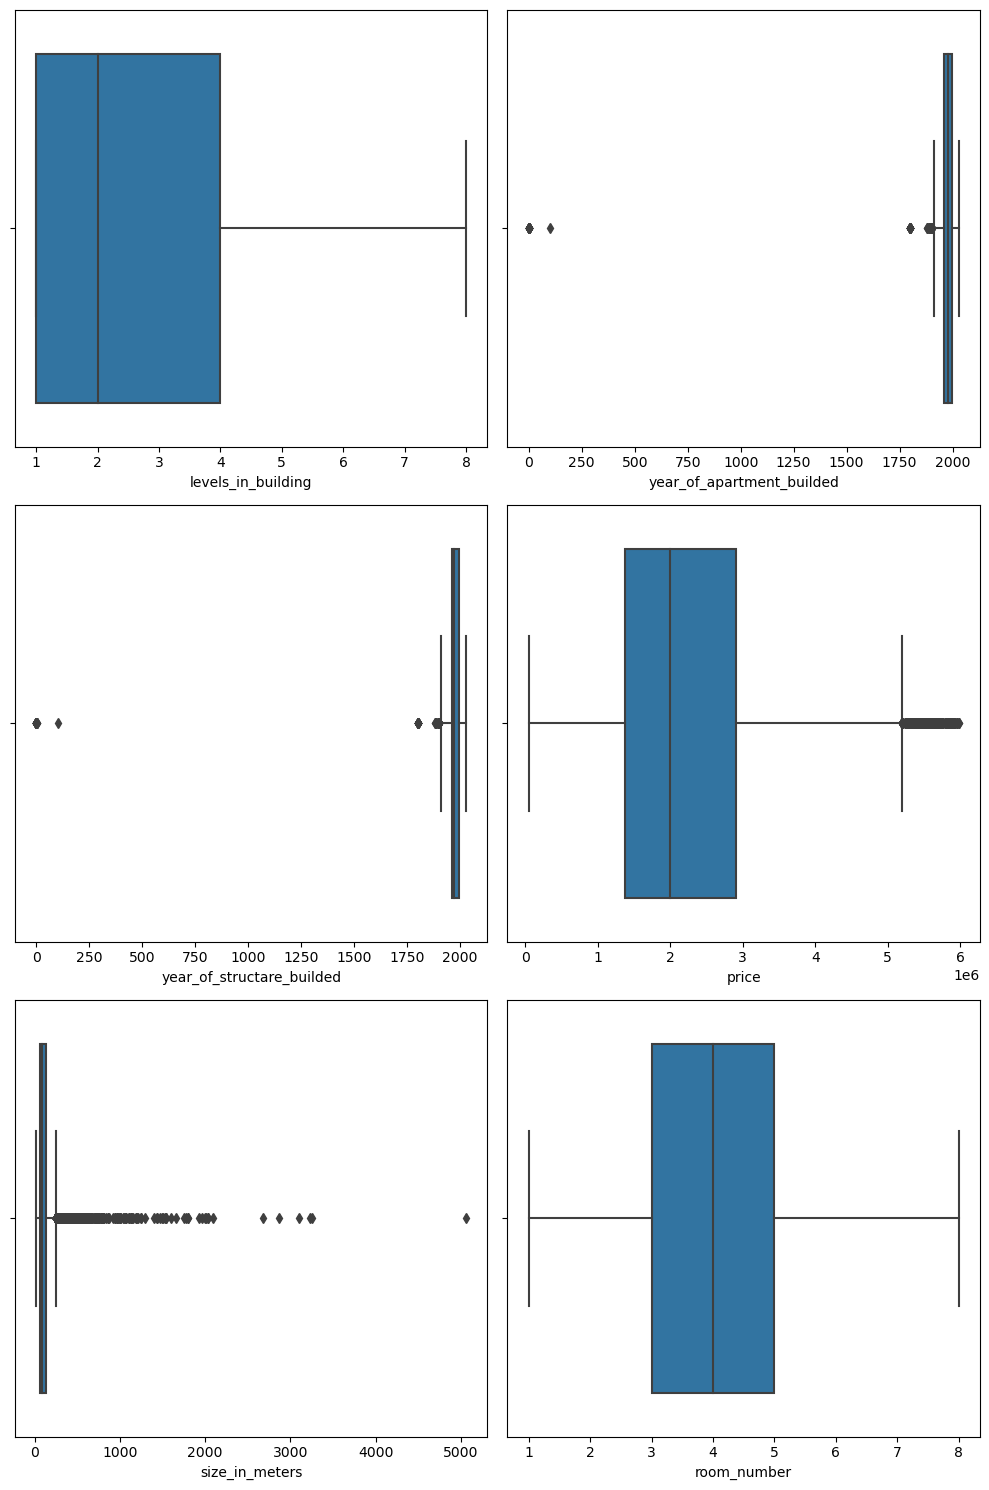

In [48]:
plt.clf()
fig, axs = plt.subplots(3, 2, figsize=(10, 15))

##############

axs[0, 0].set_xlabel('Levels in Building')
axs[0, 1].set_xlabel('Year of Apartment Built')
axs[1, 0].set_xlabel('Year of Structure Built')
axs[1, 1].set_xlabel('Price')
axs[2, 0].set_xlabel('Size in Meters')
axs[2, 1].set_xlabel('Room Number')

###########

sns.boxplot(data=gov_df, x='levels_in_building', ax=axs[0, 0])
sns.boxplot(data=gov_df, x='year_of_apartment_builded', ax=axs[0, 1])
sns.boxplot(data=gov_df, x='year_of_structare_builded', ax=axs[1, 0])
sns.boxplot(data=gov_df, x='price', ax=axs[1, 1])
sns.boxplot(data=gov_df, x='size_in_meters', ax=axs[2, 0])
sns.boxplot(data=gov_df, x='room_number', ax=axs[2, 1])

##############

plt.tight_layout()
plt.show()

From the box plots, you can make the following observations:

1) Levels in Building: The box plot shows the distribution of the number of levels in the building.
You can observe the range of values, the median (represented by the horizontal line inside the box), and the presence of any outliers.

2) Year of Apartment Built: The box plot displays the distribution of the years when the apartments were built.
You can see the spread of the data, the median year, and any potential outliers.

3) Year of Structure Built: This box plot represents the distribution of the years when the structures (buildings) were built.
It provides insights into the age distribution of the buildings in the dataset.

4) Price: The box plot shows the distribution of apartment prices.
You can observe the range of prices, the median price, and the presence of any outliers. It provides an overview of the price variability within different cities.

5) Size in Meters: This box plot displays the distribution of apartment sizes in square meters.
It allows you to compare the sizes across different cities and identify any variations or outliers.

6) Room Number: The box plot represents the distribution of the number of rooms in the apartments.
It provides information about the variability in room numbers and potential outliers.

# 2. Pairplot

the pairplot provides a comprehensive overview of the relationships and distributions within the dataset.
Scatter plots can reveal patterns such as positive or negative correlations, linear or nonlinear relationships, clusters or groups, and potential outliers. This visualization can help in identifying interesting patterns or trends in the data and guide further analysis or modeling decisions.

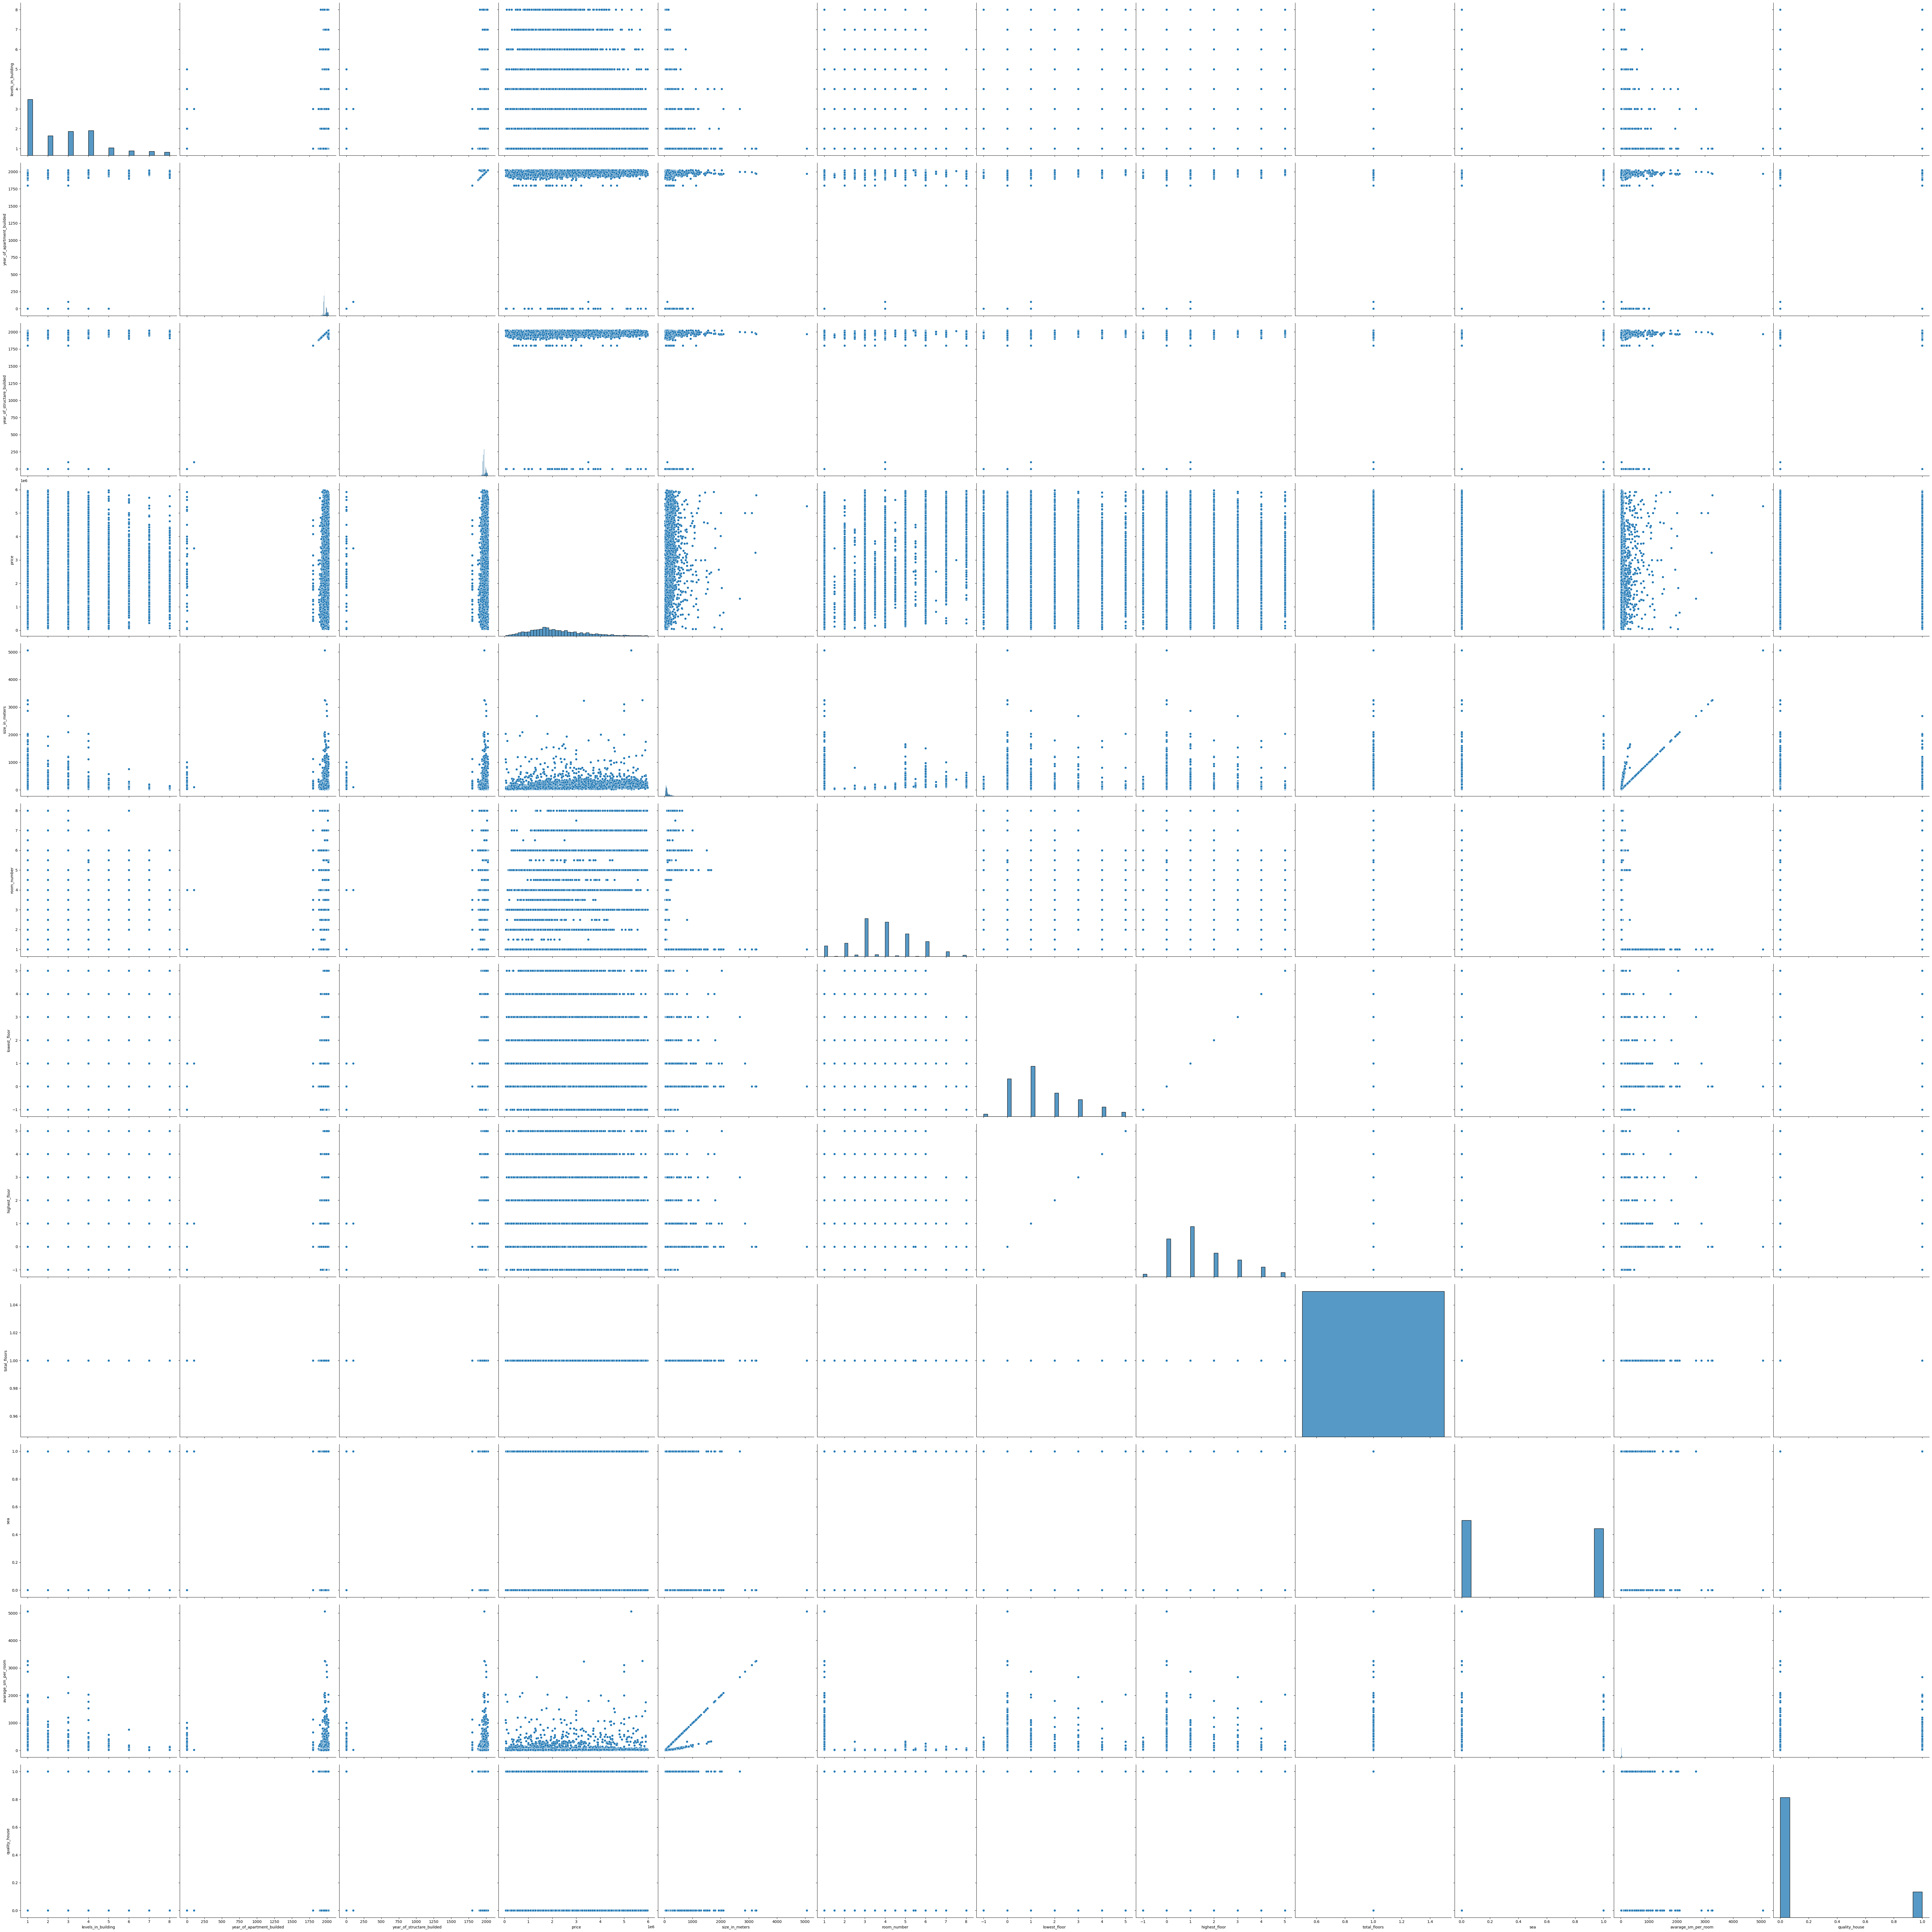

In [49]:
sns.pairplot(gov_df, height=6, palette='dark')
plt.show()

# 3. Heatmap

We use heat map to see the corrolation between every two columns:

<AxesSubplot:>

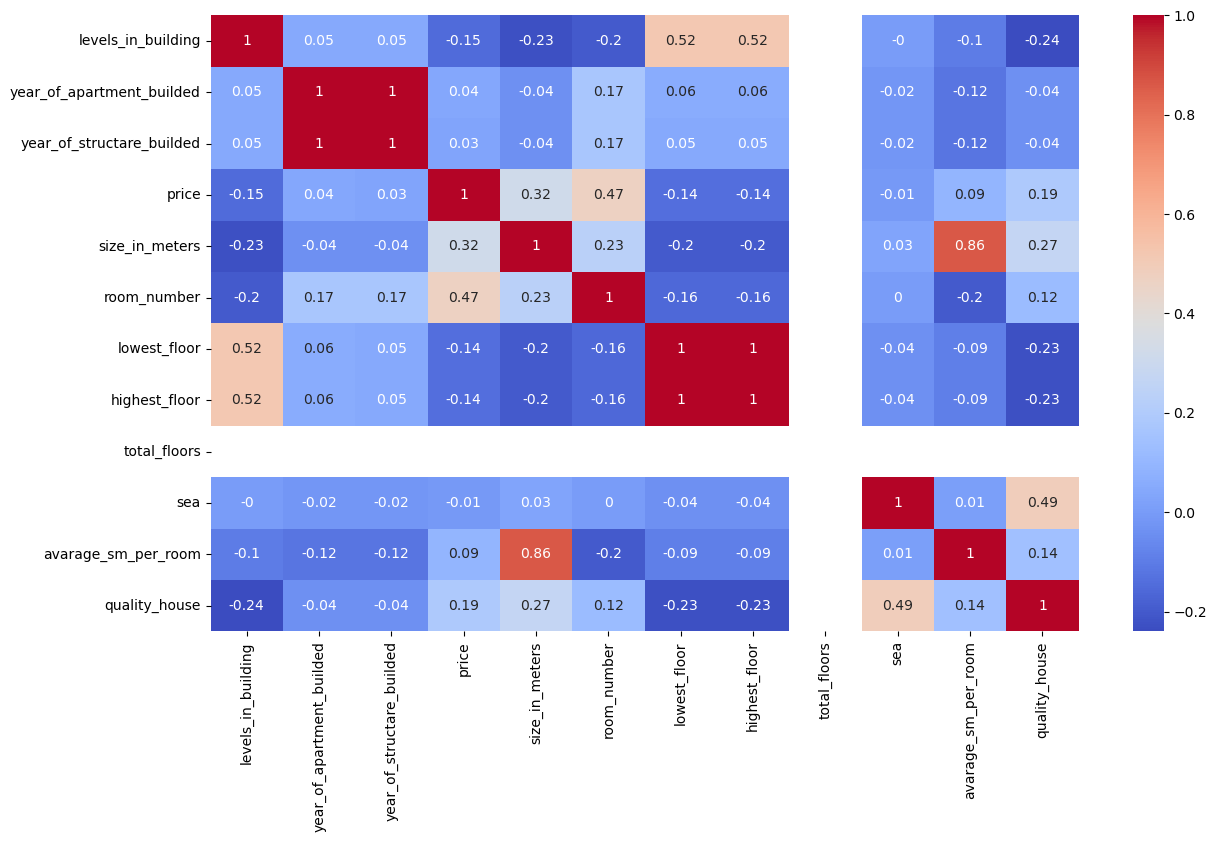

In [50]:
plt.figure(figsize=(14, 8))
corr_matrix = gov_df.corr().round(2)
sns.heatmap(data=corr_matrix,cmap='coolwarm',annot=True)

# 4. Pieplot

This graph shows partitions of our data according to cities

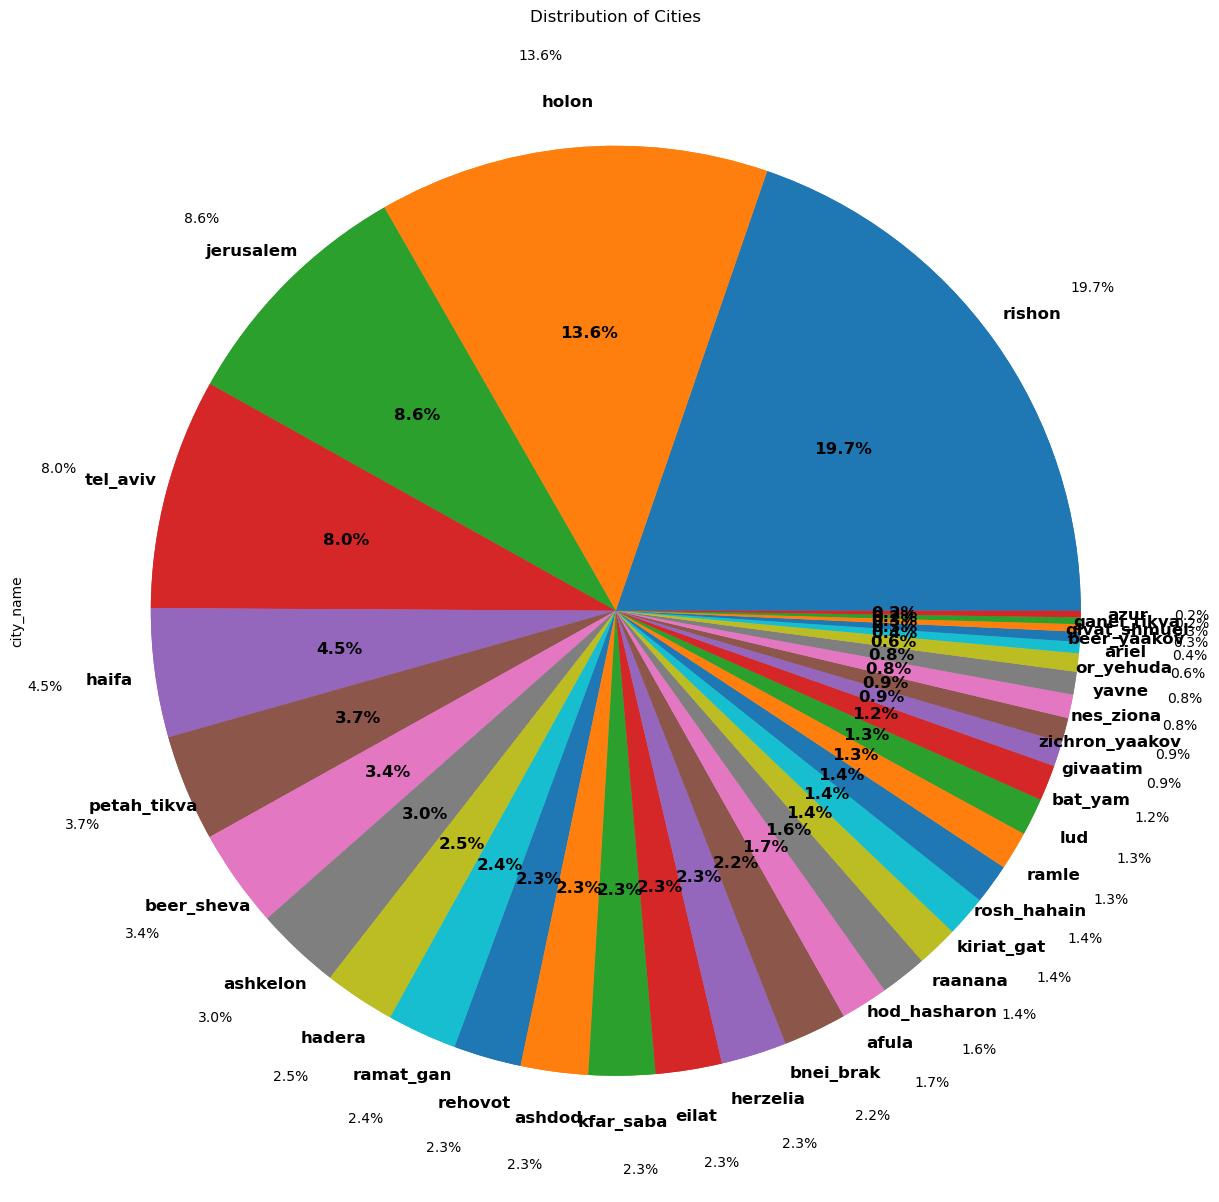

In [51]:
fig = plt.figure(figsize=(15, 20))

# Create the pie chart
pie = gov_df['city_name'].value_counts().plot(kind='pie', autopct='%1.1f%%')

# Set the title for the chart
plt.title('Distribution of Cities')

# Configure text properties for Hebrew strings
for text in pie.texts:
    text.set_fontsize(12)  # Increase the font size
    text.set_fontweight('bold')  # Set the font weight to bold
    text.set_horizontalalignment('center')  # Center align the text

# Add percentage labels outside the pie slices
total = sum(gov_df['city_name'].value_counts())
labels = [f'{100 * value / total:.1f}%' for value in gov_df['city_name'].value_counts()]
plt.pie(gov_df['city_name'].value_counts(), labels=labels, labeldistance=1.2)

# Move the legend outside of the plot
#plt.legend(gov_df['city_name'].unique(), bbox_to_anchor=(1, 1), loc='upper left')

# Add spaces between each text
plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()

Here we use the copy we saved before removing columns and encoding.
now we want to make two graphs with the columns: percentage_increase_per_year

# 5. Scatter plots

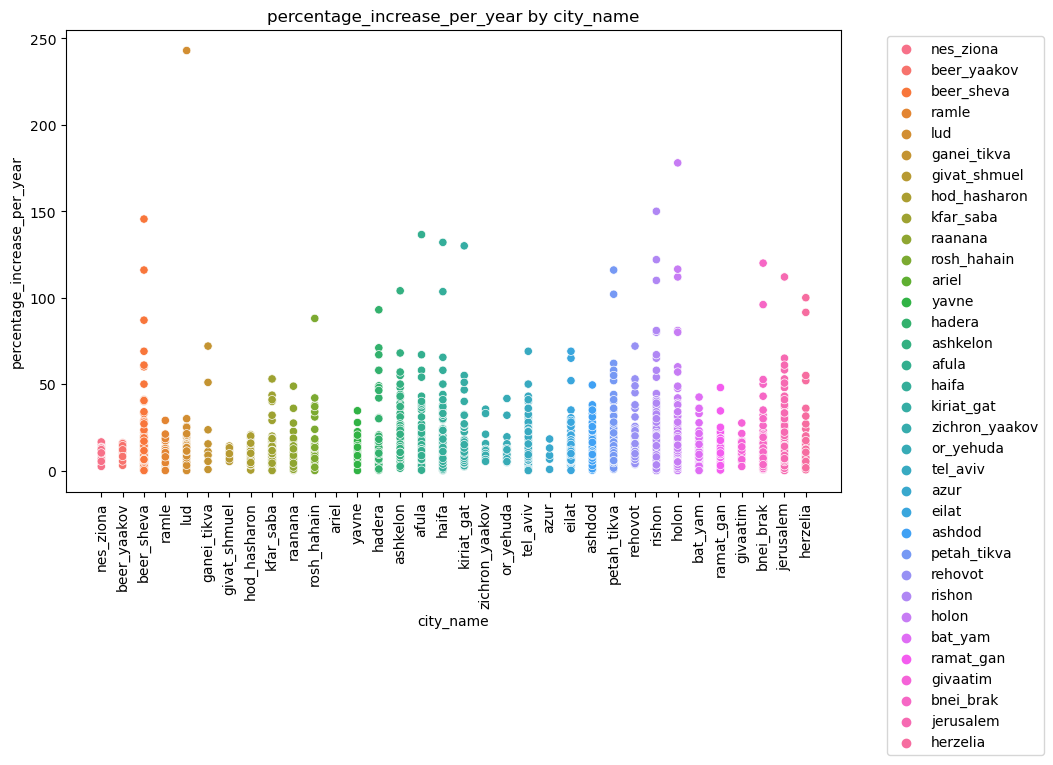

In [52]:

plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(x='city_name', y='percentage_increase_per_year', hue='city_name', data=eda_df)

# Rotate the text by 180 degrees to flip it horizontally
for text in scatter_plot.texts:
    #Ktext.set_rotation(90)
    text.set_text(text.get_text()[::-1])  # Reverse the text
    text.set_fontsize(12)  # Increase the font size
    text.set_fontweight('bold')  # Set the font weight to bold
    text.set_horizontalalignment('center')  # Center align the text

plt.xlabel('city_name')
plt.ylabel('percentage_increase_per_year')
plt.title('percentage_increase_per_year by city_name')
plt.xticks(rotation=90)

# Move the legend to the right side of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# 6. Line plot

The plot shows the trend of the percentage increase in prices per year as the years of apartment construction increase.
we can see from the year 1920 until today the price rises and in a few points there is a big jump.

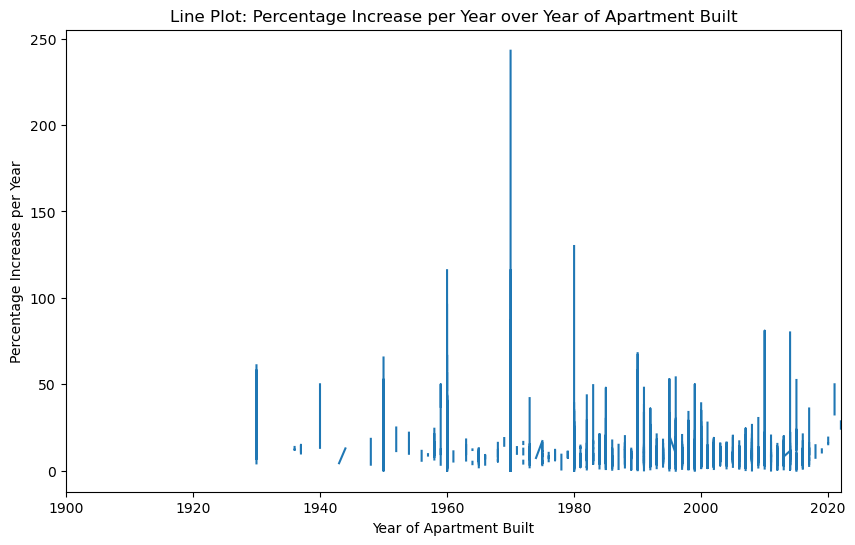

In [53]:
# Sort the dataframe by the 'year_of_apartment_builded' column
sorted_df = eda_df.sort_values('year_of_apartment_builded')

# Define the desired range of years
start_year = 1900
end_year = 2022

# Filter the dataframe based on the desired range of years
filtered_df = sorted_df[(sorted_df['year_of_apartment_builded'] >= start_year) & (sorted_df['year_of_apartment_builded'] <= end_year)]

# Create a line plot of 'percentage_increase_per_year' over 'year_of_apartment_builded' within the desired range
plt.figure(figsize=(10, 6))
plt.plot(filtered_df['year_of_apartment_builded'], filtered_df['percentage_increase_per_year'])
plt.xlabel('Year of Apartment Built')
plt.ylabel('Percentage Increase per Year')
plt.title('Line Plot: Percentage Increase per Year over Year of Apartment Built')

# Set the x-axis limits
plt.xlim(start_year, end_year)

plt.show()

# 7. Bar plot

This graph shows all of the types of real-estate that are for sale, only the relevant categories of apartment that greater then zero.
The graph shows us the count of each type in type_of_nadlan feature.

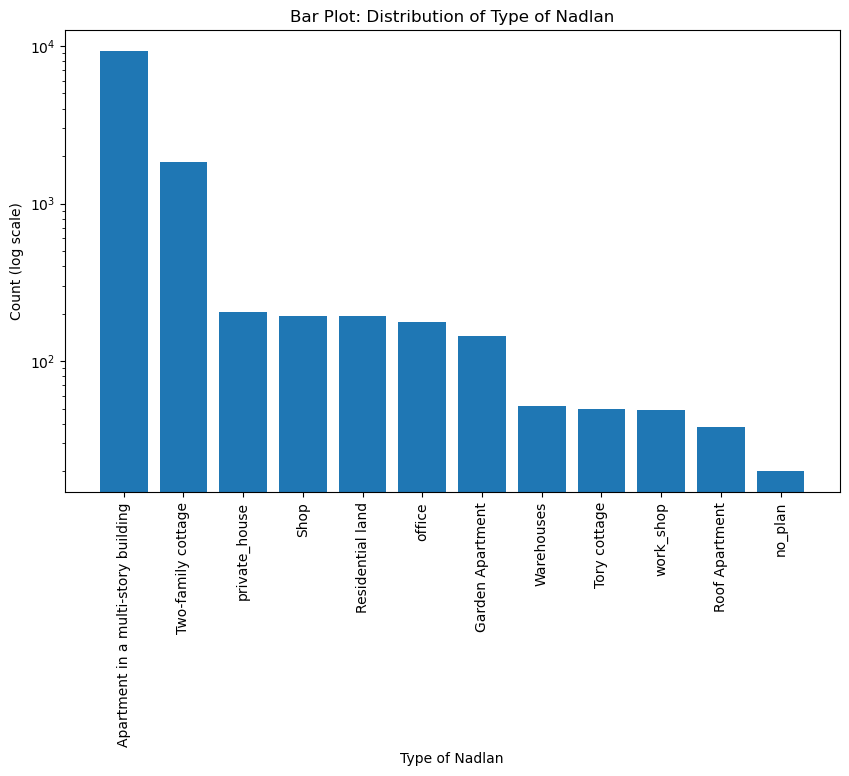

In [54]:
# Calculate the frequency of each category in the 'type_of_nadlan' variable
category_counts = gov_df['type_of_nadlan'].value_counts()

# Create a bar plot of the category counts
plt.figure(figsize=(10, 6))
plt.bar(category_counts.index, category_counts.values)
plt.xlabel('Type of Nadlan')
plt.ylabel('Count (log scale)')  # Updated y-axis label
plt.title('Bar Plot: Distribution of Type of Nadlan')

plt.xticks(rotation=90)  # Rotate x-axis labels if needed

plt.yscale('log')  # Set logarithmic scale for the y-axis

plt.show()

This graph shows in percentage how much cities got sea and the opposite

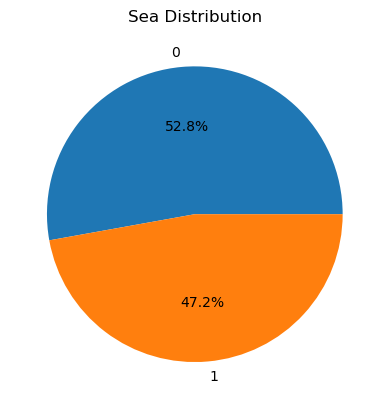

In [55]:
# Calculate the value counts of 'sea' column
sea_counts = gov_df['sea'].value_counts()

# Create a pie chart
plt.pie(sea_counts, labels=sea_counts.index, autopct='%1.1f%%')

# Set the title
plt.title('Sea Distribution')

# Show the plot
plt.show()

## now we will focus on our target feature 'price' vs all the relevent other features in the data

# 1. Box plot

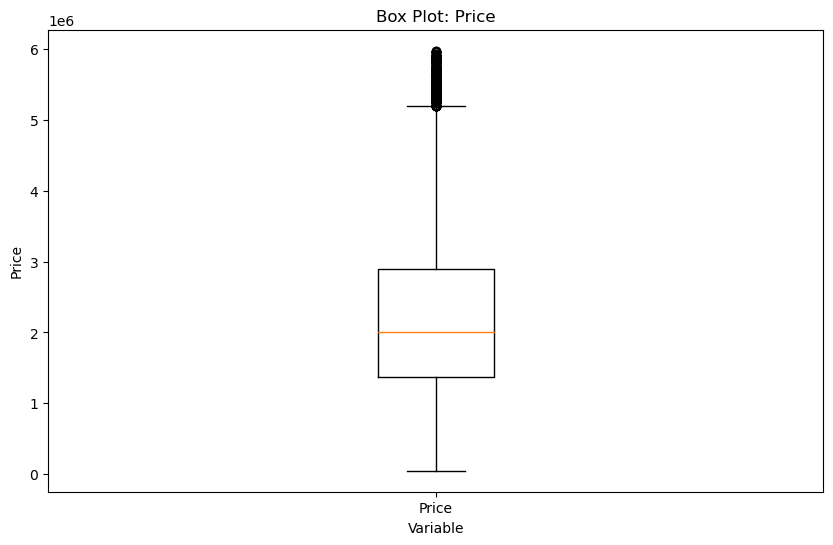

In [56]:
plt.figure(figsize=(10, 6))
plt.boxplot(gov_df['price'].dropna(), labels=['Price'])
plt.xlabel('Variable')
plt.ylabel('Price')
plt.title('Box Plot: Price')
plt.show()

From this graph we can see most the real estate is between 1-3 million shekels.

# 2. Violin plot

This graph shows the Violin Plot - Price Distribution in the data

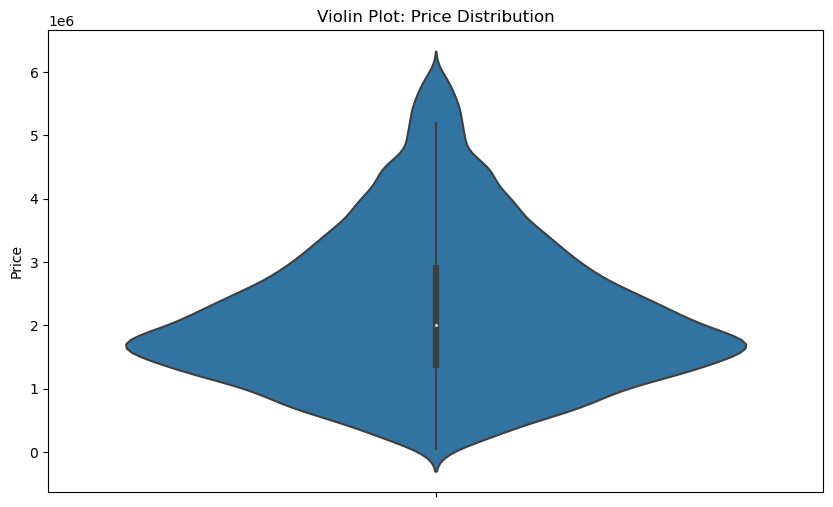

In [57]:
# Create a Violin of the 'price' variable
plt.figure(figsize=(10, 6))
sns.violinplot(y=gov_df['price'])
plt.ylabel('Price')
plt.title('Violin Plot: Price Distribution')

plt.show()

This graph show us that most of real estate costs approximatly 1.8 million.

# 3. KDE plot

This graph shows the KDE Plot - Price Distribution in the data

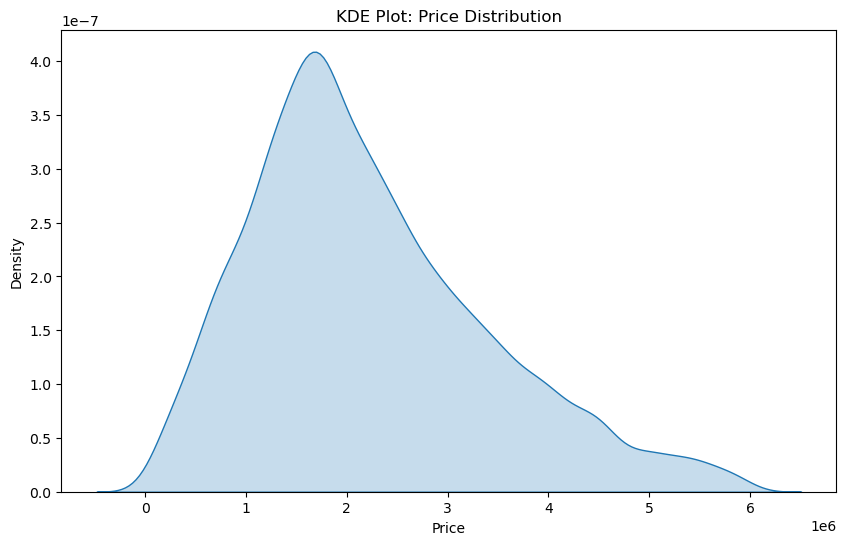

In [58]:
# Create a KDA of the 'price' variable
plt.figure(figsize=(10, 6))
sns.kdeplot(gov_df['price'], shade=True)
plt.xlabel('Price')
plt.ylabel('Density')
plt.title('KDE Plot: Price Distribution')

plt.show()

another graph to show the conclusion of our price feature

# 4. PDF plot

This graph shows the PDF Plot - Price Distribution in the data

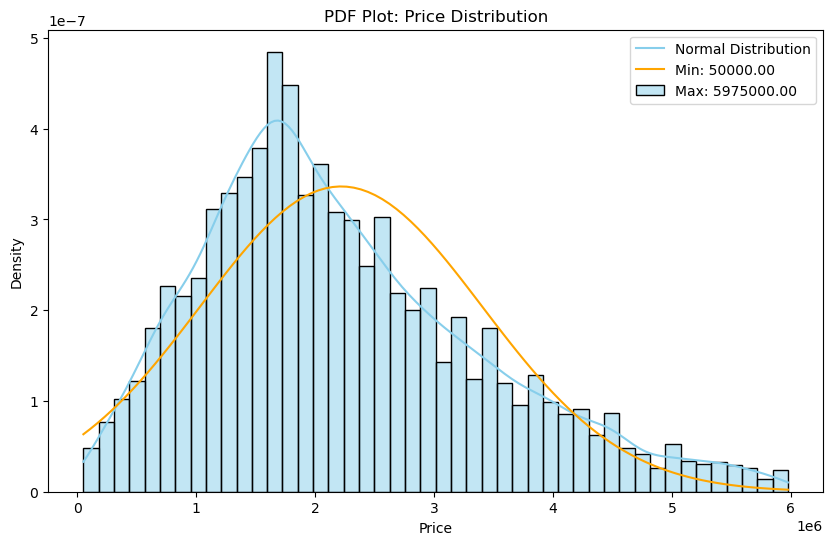

In [59]:
#Create a Probability Density Function (PDF) Plot: of the 'price' variable

plt.figure(figsize=(10, 6))
sns.histplot(gov_df['price'], kde=True, stat='density', color='skyblue')
x = np.linspace(gov_df['price'].min(), gov_df['price'].max(), 100)
plt.plot(x, stats.norm.pdf(x, gov_df['price'].mean(), gov_df['price'].std()), color='orange')
plt.xlabel('Price')
plt.ylabel('Density')
plt.title('PDF Plot: Price Distribution')

# Add legend
plt.legend(['Normal Distribution', f"Min: {gov_df['price'].min():.2f}", f"Max: {gov_df['price'].max():.2f}"])

plt.show()

here we can also see the minimum and maximum values and the distribution.

## Now, we show the 'price' feature against other features:

In [60]:
# Convert 'price' column to numeric type
gov_df['price'] = pd.to_numeric(gov_df['price'], errors='coerce')

## 1. price vs city_name

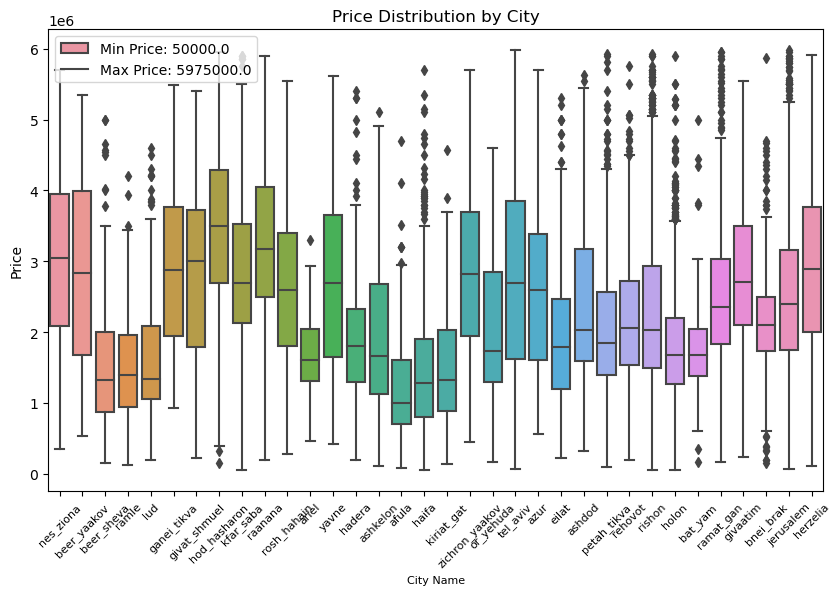

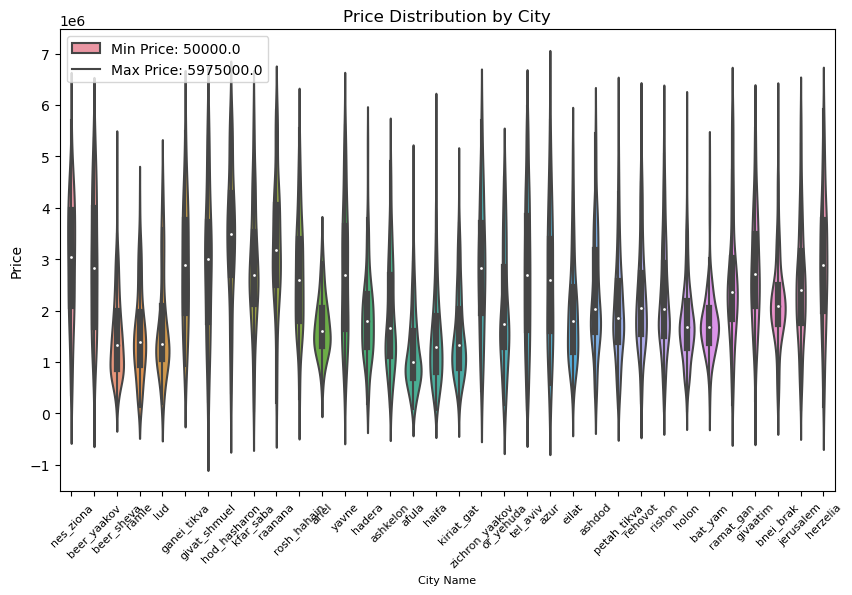

In [61]:
# Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='city_name', y='price', data=gov_df)
plt.xlabel('City Name', fontsize=8)  # Set the font size
plt.ylabel('Price')
plt.title('Price Distribution by City')

# Calculate min and max prices
min_price = gov_df['price'].min()
max_price = gov_df['price'].max()

# Add legend
plt.legend([f'Min Price: {min_price}', f'Max Price: {max_price}'], loc='upper left')

plt.xticks(rotation=45, fontsize=8)  # Set the font size and rotation
plt.show()
##################################################

# Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='city_name', y='price', data=gov_df)
plt.xlabel('City Name', fontsize=8)  # Set the font size
plt.ylabel('Price')
plt.title('Price Distribution by City')

# Calculate min and max prices
min_price = gov_df['price'].min()
max_price = gov_df['price'].max()

# Add legend
plt.legend([f'Min Price: {min_price}', f'Max Price: {max_price}'], loc='upper left')

plt.xticks(rotation=45, fontsize=8)  # Set the font size and rotation
plt.show()

this graph shows for every city the price distribution.

### Average Price by City:

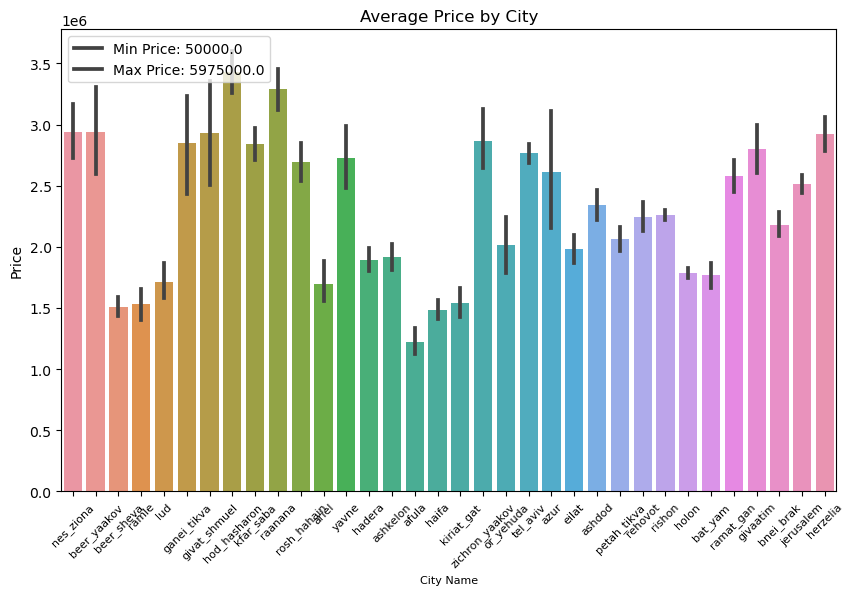

In [62]:
##############################################

# Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='city_name', y='price', data=gov_df)
plt.xlabel('City Name', fontsize=8)  # Set the font size
plt.ylabel('Price')
plt.title('Average Price by City')

# Calculate min and max prices
min_price = gov_df['price'].min()
max_price = gov_df['price'].max()

# Add legend
plt.legend([f'Min Price: {min_price}', f'Max Price: {max_price}'], loc='upper left')

plt.xticks(rotation=45, fontsize=8)  # Set the font size and rotation
plt.show()

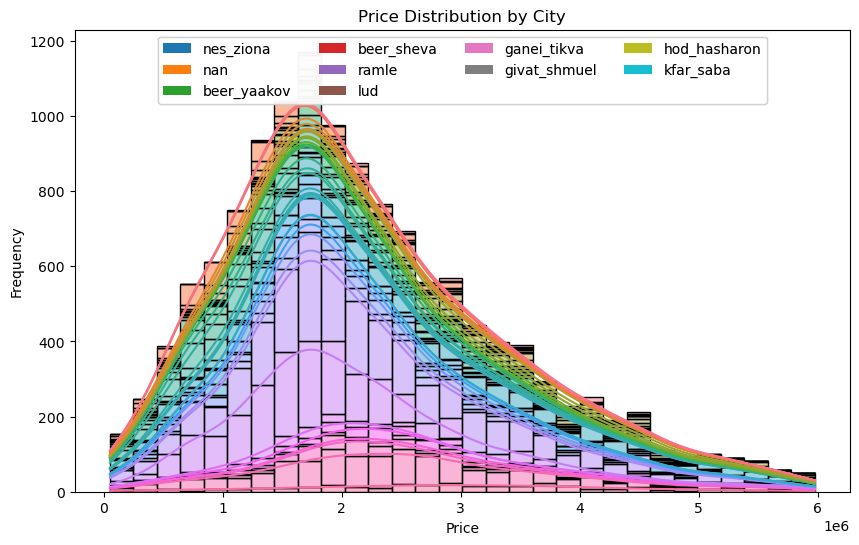

In [63]:
# Create histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=gov_df, x='price', hue='city_name', multiple='stack', bins=30, kde=True)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Price Distribution by City')

 

# Calculate min and max prices
min_price = gov_df['price'].min()
max_price = gov_df['price'].max()

 

# Create a custom legend with city names and colors
handles = []
labels = []
for city, color in zip(gov_df['city_name'].unique(), sns.color_palette()[:len(gov_df['city_name'].unique())]):
    handles.append(plt.Rectangle((0, 0), 1, 1, fc=color))
    labels.append(city)

 

plt.legend(handles, labels, loc='upper center', ncol=4)

 

# Add legend for min and max prices
plt.legend([f'Min Price: {min_price}', f'Max Price: {max_price}'], loc='upper left', facecolor='white', edgecolor='black', framealpha=1)

 

# Combine the legends
plt.gca().add_artist(plt.legend(handles, labels, loc='upper center', ncol=4))

 

plt.show()

here we show all of the distributions of all the cities in one graph.

## 2. Price vs year_of_apartment_builded

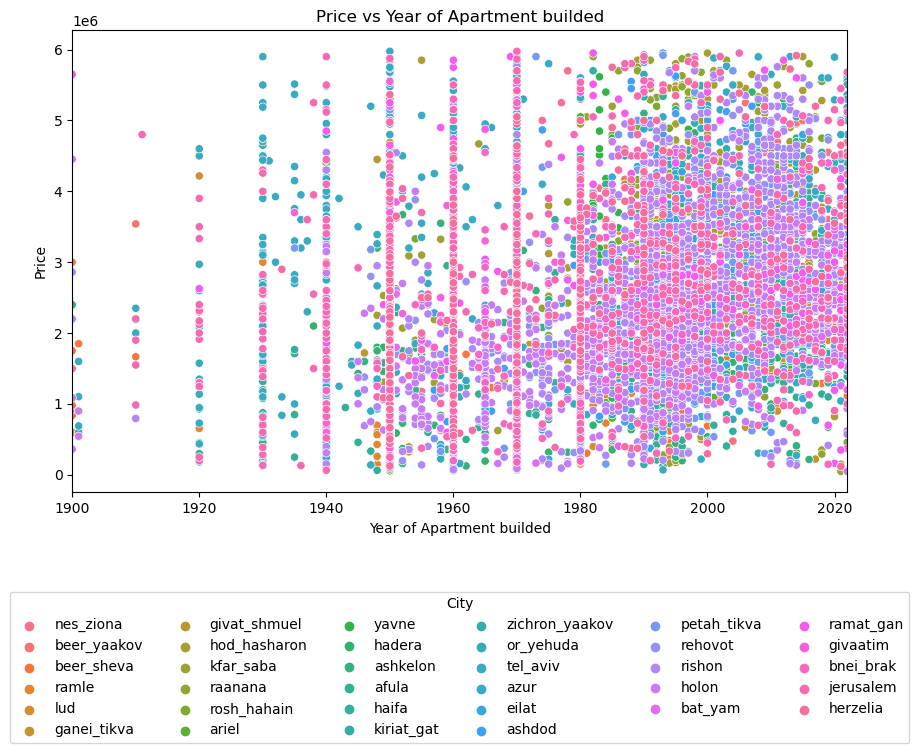

In [64]:
#Scatter Plot:
# Define the desired range of years
start_year = 1900
end_year = 2022

# Filter the dataframe based on the desired range of years
filtered_df = sorted_df[(sorted_df['year_of_apartment_builded'] >= start_year) & (sorted_df['year_of_apartment_builded'] <= end_year)]


plt.figure(figsize=(10, 6))
sns.scatterplot(data=gov_df, x='year_of_apartment_builded', y='price', hue='city_name')
plt.xlabel('Year of Apartment builded')
plt.ylabel('Price')
plt.title('Price vs Year of Apartment builded')
plt.legend(title='City', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=6)
# Set the x-axis limits
plt.xlim(start_year, end_year)

plt.show()

## 3. Price vs size_in_meters

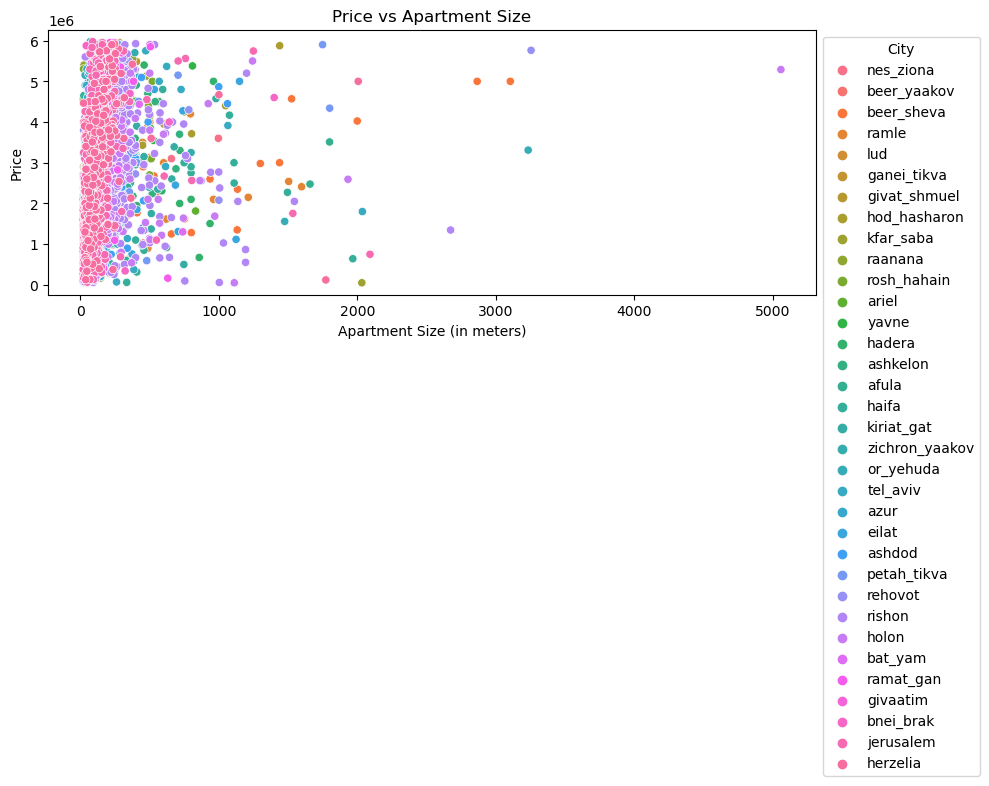

In [65]:
#Scatter Plot:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=gov_df, x='size_in_meters', y='price', hue='city_name')
plt.xlabel('Apartment Size (in meters)')
plt.ylabel('Price')
plt.title('Price vs Apartment Size')
plt.legend(title='City', bbox_to_anchor=(1, 1), loc='upper left', ncol=1)  # Move the legend to the right side
plt.tight_layout()
plt.show()

here we can that gosh dan district (all the pink dots) the price is higher per meter.

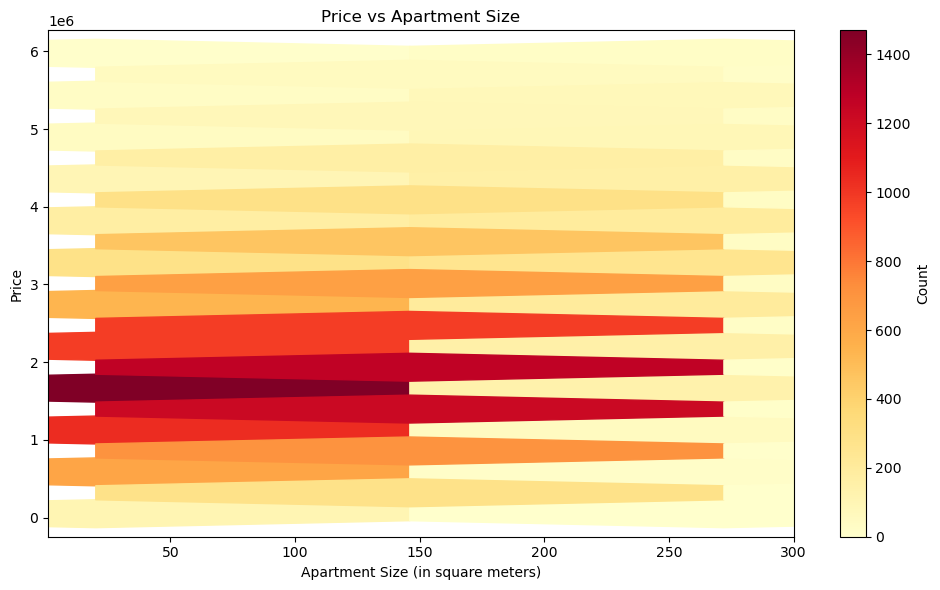

In [66]:
#####################################################

#Hexbin Plot:
plt.figure(figsize=(10, 6))
plt.hexbin(x=gov_df['size_in_meters'], y=gov_df['price'], gridsize=20, cmap='YlOrRd')
plt.xlabel('Apartment Size (in square meters)')
plt.ylabel('Price')
plt.title('Price vs Apartment Size')
plt.colorbar(label='Count')
plt.xlim(1, 300)
plt.tight_layout()
plt.show()

in this graph we can see the count of apartment of the relevant price.
this graph confirmes the 1.8 million avarage apartment price. (the darker areas in the graph)
the darker the graph goes the count of the apartment of this price is higher.

## 4. Price vs room_number

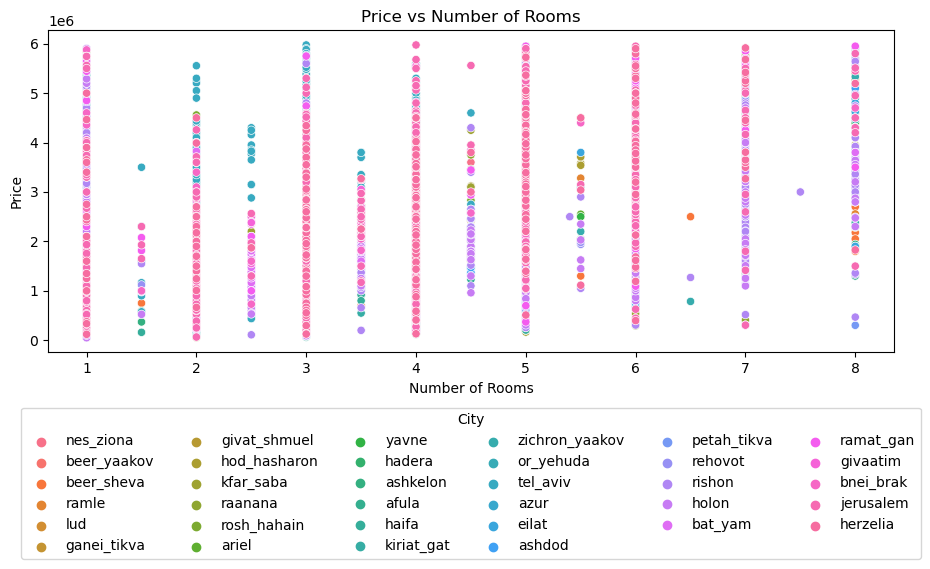

In [67]:
#Scatter Plot:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=gov_df, x='room_number', y='price', hue='city_name')
plt.xlabel('Number of Rooms')
plt.ylabel('Price')
plt.title('Price vs Number of Rooms')
plt.legend(title='City', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6)
plt.tight_layout()
plt.show()

The graph shows the price relative to each apartment according to the city it is located in and the number of rooms it has.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


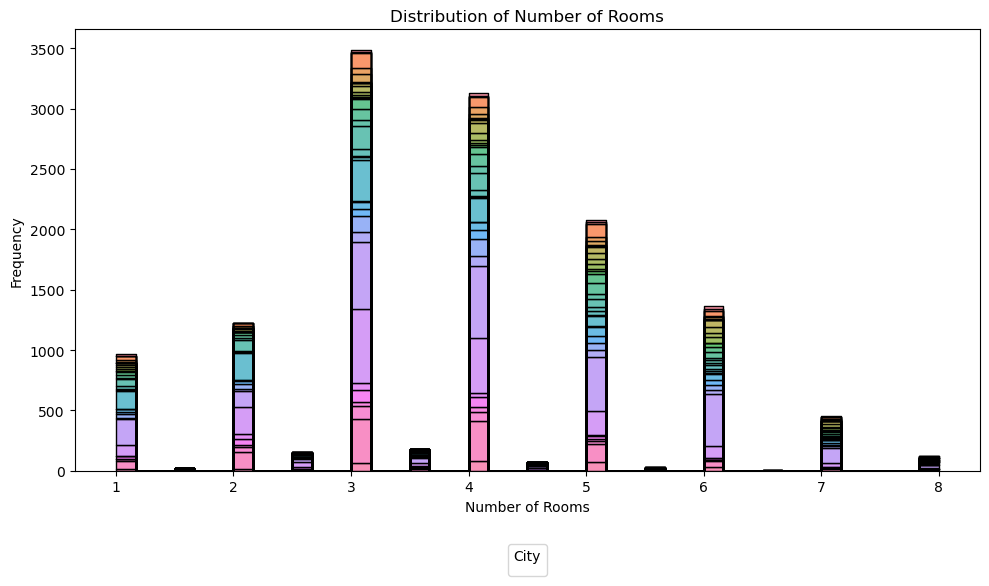

In [68]:
####################################################

#Histogram:
plt.figure(figsize=(10, 6))
sns.histplot(data=gov_df, x='room_number', hue='city_name', multiple='stack', element='step', legend=True)
plt.xlabel('Number of Rooms')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Rooms')
plt.legend(title='City', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6)
plt.tight_layout()
plt.show()

In this graph, you can see the distribution of apartments by the number of rooms.

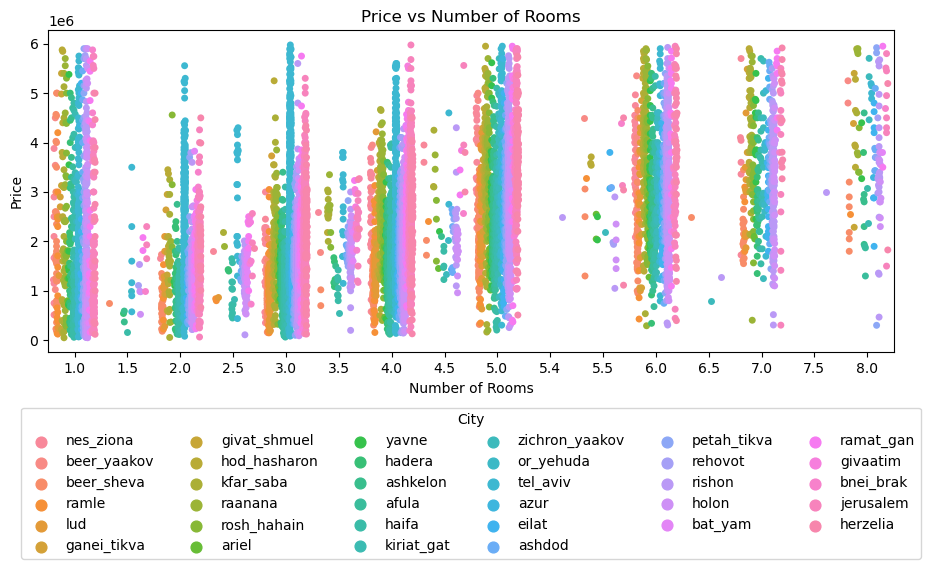

In [69]:
#############################################

#Swarm Plot:
plt.figure(figsize=(10, 6))
sns.swarmplot(data=gov_df, x='room_number', y='price', hue='city_name', dodge=True)
plt.xlabel('Number of Rooms')
plt.ylabel('Price')
plt.title('Price vs Number of Rooms')
plt.legend(title='City', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6)
plt.tight_layout()
plt.show()

In this graph we can see that most of the apartment in the center of isreal have three or four rooms.
Here, you can also see that as the number of rooms increases, the price of the apartment becomes more expensive, and the apartments in the center are the most expensive.

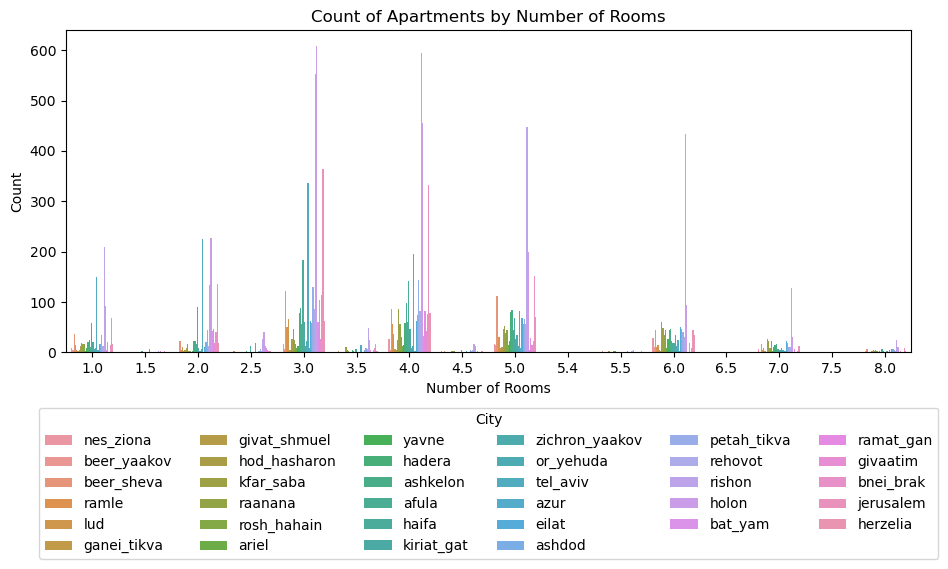

In [70]:
#############################################

#Count Plot:
plt.figure(figsize=(10, 6))
sns.countplot(data=gov_df, x='room_number', hue='city_name')
plt.xlabel('Number of Rooms')
plt.ylabel('Count')
plt.title('Count of Apartments by Number of Rooms')
plt.legend(title='City', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=6)
plt.tight_layout()
plt.show()

## Here, we showed graphs of two features from our data against the price feature: price - room number - size in metters

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


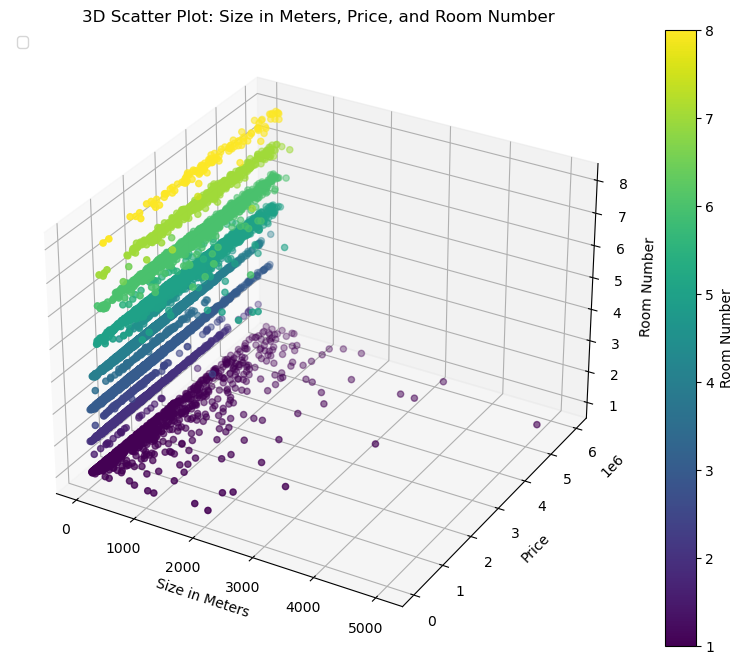

In [71]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

x = gov_df['size_in_meters']
y = gov_df['price']
z = gov_df['room_number']
colors = gov_df['room_number']

scatter = ax.scatter(x, y, z, c=colors, cmap='viridis', marker='o')

ax.set_xlabel('Size in Meters')
ax.set_ylabel('Price')
ax.set_zlabel('Room Number')

# Add colorbar legend
cbar = fig.colorbar(scatter)
cbar.set_label('Room Number')

# Add legends for axes
ax.legend(loc='upper left')

plt.title('3D Scatter Plot: Size in Meters, Price, and Room Number')
plt.show()

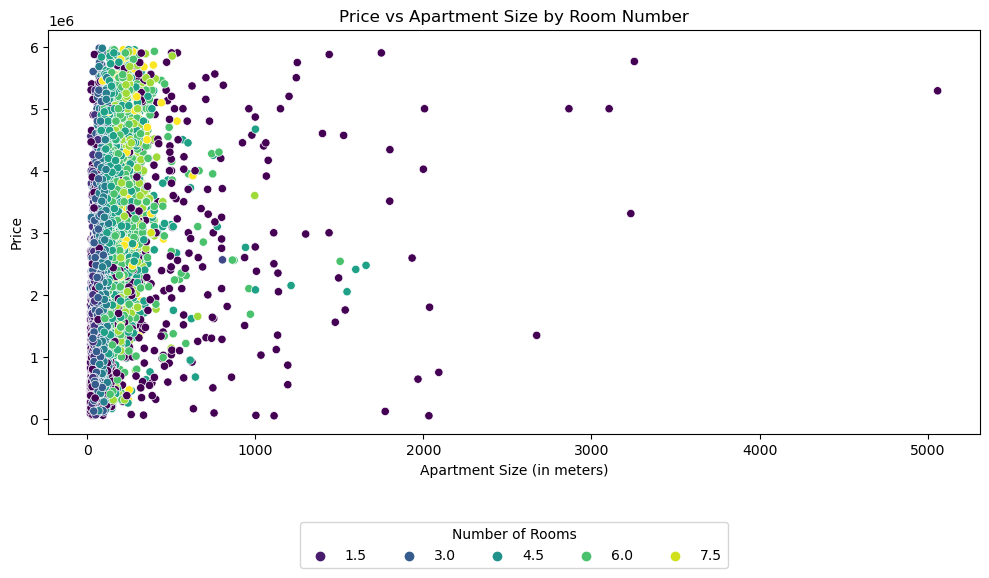

In [72]:
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=gov_df, x='size_in_meters', y='price', hue='room_number', palette='viridis')
plt.xlabel('Apartment Size (in meters)')
plt.ylabel('Price')
plt.title('Price vs Apartment Size by Room Number')
plt.legend(title='Number of Rooms', bbox_to_anchor=(0.5, -0.2), loc='upper center', ncol=6)
plt.tight_layout()
plt.show()

# 3. Parallel Coordinates Plot:

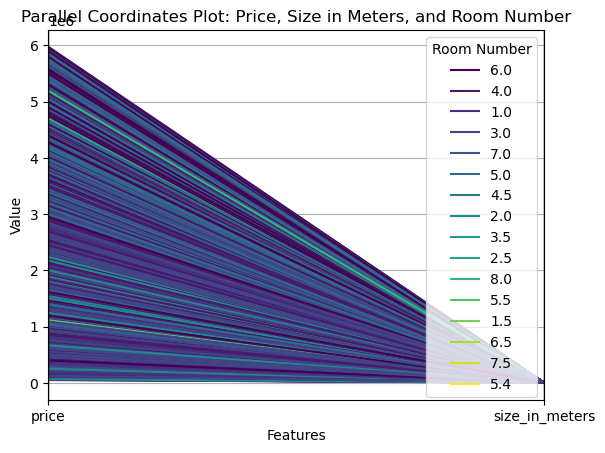

In [73]:
#plt.figure(figsize=(10, 6))

columns = ['price', 'size_in_meters', 'room_number']
data = gov_df[columns]

pd.plotting.parallel_coordinates(data, 'room_number', colormap='viridis')

plt.xlabel('Features')
plt.ylabel('Value')
plt.title('Parallel Coordinates Plot: Price, Size in Meters, and Room Number')
plt.legend(title='Room Number')
plt.show()

In all of these graphs that combine the three columns together, we can see the relationship between price, number of rooms, and apartment size.

We can conclude that both the number of rooms and the size of the apartment have a direct impact on the price. As the number of rooms and the size of the apartment increase, the price becomes more expensive.

Additionally, as seen in the previous graphs, most of the apartments have 3-4 rooms, and as we move closer to the center, the price increases (as indicated by the colors, as we explained in the previous graphs).

From this stage we can see some linear connection between some features - we will try running a linear regression model on our data and if the results will be insufficiant we will try other models.

## Machine Learning

In [74]:
gov_df.dropna(inplace=True)

In [75]:
encoded_df = gov_df.copy()

In [76]:
encoded_df = encoded_df.drop(columns=['adress','day_of_sale'])

For encoding our data we used the replace_categories function which encodes the data accordingly to the price.

In [77]:
cat_vars = ['city_name', 'type_of_nadlan', 'district']

In [78]:
for var in cat_vars:
    replace_categories(encoded_df, var, 'price')

Splitting the data to train and test sets:

In [79]:
y = encoded_df['price']
X = encoded_df.drop(['price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
                                    encoded_df.drop('price',axis=1),
                                    encoded_df['price'],
                                    test_size=0.2,
                                    random_state=0)

Making a scaled data train and test variables for comparing:

In [80]:
sc_X = StandardScaler()

X2_train = sc_X.fit_transform(X_train)
X2_test = sc_X.fit_transform(X_test)
y2_train = y_train
y2_test = y_test

## Linear regression

Training the model:

In [81]:
lm1 = LinearRegression()
lm1.fit(X_train,y_train)

lm2 = LinearRegression()
lm2.fit(X2_train,y2_train)

LinearRegression()

Predicting:

In [82]:
lm1_pred = lm1.predict(X_test)
lm2_pred = lm2.predict(X2_test)

Evaluation:

In [83]:
print('Linear Regression Performance:')

print('\nall features, No scaling:')
print('MAE:', metrics.mean_absolute_error(y_test, lm1_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, lm1_pred)))
print('R2_Score: ', metrics.r2_score(y_test, lm1_pred))

print('\nall features, with scaling:')
print('MAE:', metrics.mean_absolute_error(y2_test, lm2_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y2_test, lm2_pred)))
print('R2_Score: ', metrics.r2_score(y2_test, lm2_pred))

Linear Regression Performance:

all features, No scaling:
MAE: 629124.7165459984
RMSE: 871234.3473640673
R2_Score:  0.4454347697007074

all features, with scaling:
MAE: 636741.0202223955
RMSE: 879914.2330339678
R2_Score:  0.4343297416228762


# Random forest

The Random Forest model proved to be the most appropriate model giving the highest value of the R-square and the minimum Root Mean Square Error Value. Hence, it can be concluded that the Random Forest Model is the most appropriate model for this dataset and should be used for predicting housing prices.

Training model: 

In [84]:
rf1 = RandomForestRegressor(random_state=101, n_estimators=200)
rf2 = RandomForestRegressor(random_state=101, n_estimators=200)

rf1.fit(X_train, y_train)
rf2.fit(X2_train, y2_train)

RandomForestRegressor(n_estimators=200, random_state=101)

Predicting:

In [85]:
rf1_pred = rf1.predict(X_test)
rf2_pred = rf2.predict(X2_test)

Evaluating:

In [86]:
print('Random Forest Performance:')

print('\nall features, No scaling:')
print('MAE:', metrics.mean_absolute_error(y_test, rf1_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rf1_pred)))
print('R2_Score: ', metrics.r2_score(y_test, rf1_pred))

print('\nall features, with scaling:')
print('MAE:', metrics.mean_absolute_error(y2_test, rf2_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y2_test, rf2_pred)))
print('R2_Score: ', metrics.r2_score(y2_test, rf2_pred))



Random Forest Performance:

all features, No scaling:
MAE: 580221.4013744261
RMSE: 813639.6626714446
R2_Score:  0.5163325267653278

all features, with scaling:
MAE: 613918.0989199588
RMSE: 843213.5221300735
R2_Score:  0.4805332138550409


We use feat_importance function to see which features are more important:

In [87]:
importance = feat_importance(rf1,X_train)
importance[:]

Importance
size_in_meters               0.227957
room_number                  0.209517
city_name                    0.190096
avarage_sm_per_room          0.105372
year_of_apartment_builded    0.069635
year_of_structare_builded    0.052964
levels_in_building           0.038015
type_of_nadlan               0.031844
lowest_floor                 0.022294
highest_floor                0.021817
sea                          0.016317
district                     0.009516
quality_house                0.004655
total_floors                 0.000000

<AxesSubplot:>

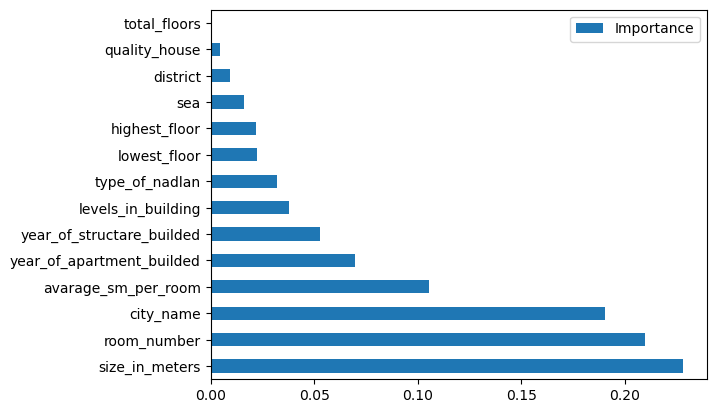

In [88]:
importance.plot(kind='barh')

In [89]:
#Discarding features with feature coefficients less than 0.01
to_keep = importance[importance['Importance'] > 0.01].index
df_raw_train_keep = X_train[to_keep].copy()
df_raw_test_keep = X_test[to_keep].copy()

Now, we use RandomizedSearchCV to tune the hyper-parameters of the random forest model

In [90]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.arange(start = 10, stop = 2000, step = 10)]
max_features = [0.5,'auto', 'sqrt','log2']
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# First create the base model to tune
m = RandomForestRegressor()
# Fit the random search model
m_random = RandomizedSearchCV(estimator = m, param_distributions = random_grid, n_iter = 1, cv = 3, verbose=2, random_state=42, n_jobs = -1)
m_random.fit(X_train, y_train)
m_random.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\omerm\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


{'n_estimators': 650,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'bootstrap': True}

Here we use the parameters we got and train a new model:

In [91]:
rf1 = RandomForestRegressor(random_state=101, n_estimators=650, min_samples_leaf=2,max_features= 1,
 bootstrap = True )
rf2 = RandomForestRegressor(random_state=101, n_estimators=650, min_samples_leaf=2,max_features= 1,
 bootstrap = True )

rf1.fit(X_train, y_train)
rf2.fit(X2_train, y2_train)

RandomForestRegressor(max_features=1, min_samples_leaf=2, n_estimators=650,
                      random_state=101)

Predicting:

In [92]:
rf1_pred = rf1.predict(X_test)
rf2_pred = rf2.predict(X2_test)

  Evaluating:

In [93]:
print('Random Forest Performance:')

print('\nall features, No scaling:')
print('MAE:', metrics.mean_absolute_error(y_test, rf1_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rf1_pred)))
print('R2_Score: ', metrics.r2_score(y_test, rf1_pred))

print('\nall features, with scaling:')
print('MAE:', metrics.mean_absolute_error(y2_test, rf2_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y2_test, rf2_pred)))
print('R2_Score: ', metrics.r2_score(y2_test, rf2_pred))

Random Forest Performance:

all features, No scaling:
MAE: 585154.2139920768
RMSE: 807714.015547082
R2_Score:  0.5233518655897218

all features, with scaling:
MAE: 609529.4860044254
RMSE: 826676.424942126
R2_Score:  0.500708968541634


We started with a linear regression machine learning model. The results of the model were low and unsatisfactory, so we tried several other models such as Random Forest, Gradient Boosting and XgBoost, and found that Random forest was the most suitable for our needs.

The linear regression model was able to predict the price with an accuracy of 44%. Afterward, we can see that random forest gave us 50% accuracy before optimization. We performed optimization on the random forest model through hyperparameter tuning and managed to achieve an additional two percentage points of improvement (52%). It is also evident that the data that did not undergo normalization provides higher accuracy percentages.

After all our efforts, we managed to achieve 52% success rate for the final model. We believe that it is possible to achieve higher percentages, but we were not successful in doing so. We made many changes to the data beyond just cleaning, including feature engineering, scaling, and removing columns that did not correlate with the price.

Despite all the improvements, we were not able to reach the high percentages that could define a model as highly accurate. We learned a lot from this project about teamwork,Python programming, advance machine learning, data analysis and using Jupyter notebooks.

The learning format through the online course was very interesting, and it was nice to integrate this style more during our degree.

# Links and data sources

Gov-nadlan: https://www.nadlan.gov.il

Homeless: https://www.homeless.co.il/ 

campus il: https://campus.gov.il/ 

Chatgpt: https://chat.openai.com/ 

random-forest: https://towardsdatascience.com/predicting-housing-prices-using-a-scikit-learns-random-forest-model-e736b59d56c5 

parameters of machine learning: https://www.projectpro.io/recipes/find-optimal-parameters-using-randomizedsearchcv-for-regression

house-rent-prediction data example: https://www.kaggle.com/code/rkb0023/exploratory-data-analysis-house-rent-prediction/notebook

find-optimal: https://www.projectpro.io/recipes/find-optimal-parameters-using-randomizedsearchcv-for-regression

random-forest-model: https://towardsdatascience.com/predicting-housing-prices-using-a-scikit-learns-random-forest-model-e736b59d56c5

exploratory-data-analysis-eda: https://medium.com/swlh/exploratory-data-analysis-eda-on-residential-properties-in-hyderabad-fd246e1bf71c

how-to-handle-overfitting: https://medium.datadriveninvestor.com/how-to-handle-overfitting-and-underfitting-470a1f7389fe

learning-curves-for-diagnosing: https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

exploratory-data-analysis: https://www.kaggle.com/code/rkb0023/exploratory-data-analysis-house-rent-prediction/notebook